# Streaming flow policy in the Push-T environment
```{note}
*This notebook is adapted from [Diffusion policy's Colab notebook](https://colab.research.google.com/drive/1gxdkgRVfM55zihY9TFLja97cSVZOZq2B?usp=sharing) with an implementation of [Streaming flow policy](https://streaming-flow-policy.github.io/).*
```

In [1]:
# Standard imports
import collections
from dataclasses import dataclass
import gdown
import os
import numpy as np
import math
import torch
from torch import Tensor
import torch.nn as nn
from tqdm.auto import tqdm
from typing import List, Literal, Sequence, Tuple, Union

# Imports for diffusion policy
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler

# Imports for the Push-T environment
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
import jupyviz as jviz

# always call this first
from streaming_flow_policy.all import set_random_seed
set_random_seed(0)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/home/users/oscar/miniconda/envs/sfp/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## **Push-T environment in PyMunk**
Here, we define a PyMunk-based `PushTEnv` environment.
This implementation is adapted from [Diffusion policy](https://diffusion-policy.cs.columbia.edu/), which in turn is adapted from [Implicit Behavior Cloning](https://implicitbc.github.io/).
The goal is to push the gray T-block to its target position and orientation denoted in green.

<img src="./pusht.png" width="256px" style="display: block; margin-left: auto; margin-right: auto;" class="centered">

In [4]:
positive_y_is_up: bool = False
"""Make increasing values of y point upwards.

When True::            When False::

    y                   +------ > x
    ^                   |
    |      . (3, 3)     |   . (2, 2)
    |                   |
    |   . (2, 2)        |      . (3, 3)
    |                   v
    +------ > x         y
"""

def to_pygame(p: Tuple[float, float], surface: pygame.Surface) -> Tuple[int, int]:
    """Convenience method to convert pymunk coordinates to pygame surface
    local coordinates.

    Note that in case positive_y_is_up is False, this function wont actually do
    anything except converting the point to integers.
    """
    if positive_y_is_up:
        return round(p[0]), surface.get_height() - round(p[1])
    else:
        return round(p[0]), round(p[1])


def light_color(color: SpaceDebugColor):
    color = np.minimum(1.2 * np.float32([color.r, color.g, color.b, color.a]), np.float32([255]))
    color = SpaceDebugColor(r=color[0], g=color[1], b=color[2], a=color[3])
    return color

class DrawOptions(pymunk.SpaceDebugDrawOptions):
    def __init__(self, surface: pygame.Surface) -> None:
        """Draw a pymunk.Space on a pygame.Surface object.

        Typical usage::

        >>> import pymunk
        >>> surface = pygame.Surface((10,10))
        >>> space = pymunk.Space()
        >>> options = pymunk.pygame_util.DrawOptions(surface)
        >>> space.debug_draw(options)

        You can control the color of a shape by setting shape.color to the color
        you want it drawn in::

        >>> c = pymunk.Circle(None, 10)
        >>> c.color = pygame.Color("pink")

        See pygame_util.demo.py for a full example

        Since pygame uses a coordiante system where y points down (in contrast
        to many other cases), you either have to make the physics simulation
        with Pymunk also behave in that way, or flip everything when you draw.

        The easiest is probably to just make the simulation behave the same
        way as Pygame does. In that way all coordinates used are in the same
        orientation and easy to reason about::

        >>> space = pymunk.Space()
        >>> space.gravity = (0, -1000)
        >>> body = pymunk.Body()
        >>> body.position = (0, 0) # will be positioned in the top left corner
        >>> space.debug_draw(options)

        To flip the drawing its possible to set the module property
        :py:data:`positive_y_is_up` to True. Then the pygame drawing will flip
        the simulation upside down before drawing::

        >>> positive_y_is_up = True
        >>> body = pymunk.Body()
        >>> body.position = (0, 0)
        >>> # Body will be position in bottom left corner

        :Parameters:
                surface : pygame.Surface
                    Surface that the objects will be drawn on
        """
        self.surface = surface
        super(DrawOptions, self).__init__()

    def draw_circle(
        self,
        pos: Vec2d,
        angle: float,
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p = to_pygame(pos, self.surface)

        pygame.draw.circle(self.surface, fill_color.as_int(), p, round(radius), 0)
        pygame.draw.circle(self.surface, light_color(fill_color).as_int(), p, round(radius-4), 0)

        circle_edge = pos + Vec2d(radius, 0).rotated(angle)
        p2 = to_pygame(circle_edge, self.surface)
        line_r = 2 if radius > 20 else 1
        # pygame.draw.lines(self.surface, outline_color.as_int(), False, [p, p2], line_r)

    def draw_segment(self, a: Vec2d, b: Vec2d, color: SpaceDebugColor) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        pygame.draw.aalines(self.surface, color.as_int(), False, [p1, p2])

    def draw_fat_segment(
        self,
        a: Tuple[float, float],
        b: Tuple[float, float],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        r = round(max(1, radius * 2))
        pygame.draw.lines(self.surface, fill_color.as_int(), False, [p1, p2], r)
        if r > 2:
            orthog = [abs(p2[1] - p1[1]), abs(p2[0] - p1[0])]
            if orthog[0] == 0 and orthog[1] == 0:
                return
            scale = radius / (orthog[0] * orthog[0] + orthog[1] * orthog[1]) ** 0.5
            orthog[0] = round(orthog[0] * scale)
            orthog[1] = round(orthog[1] * scale)
            points = [
                (p1[0] - orthog[0], p1[1] - orthog[1]),
                (p1[0] + orthog[0], p1[1] + orthog[1]),
                (p2[0] + orthog[0], p2[1] + orthog[1]),
                (p2[0] - orthog[0], p2[1] - orthog[1]),
            ]
            pygame.draw.polygon(self.surface, fill_color.as_int(), points)
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p1[0]), round(p1[1])),
                round(radius),
            )
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p2[0]), round(p2[1])),
                round(radius),
            )

    def draw_polygon(
        self,
        verts: Sequence[Tuple[float, float]],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        ps = [to_pygame(v, self.surface) for v in verts]
        ps += [ps[0]]

        radius = 2
        pygame.draw.polygon(self.surface, light_color(fill_color).as_int(), ps)

        if radius > 0:
            for i in range(len(verts)):
                a = verts[i]
                b = verts[(i + 1) % len(verts)]
                self.draw_fat_segment(a, b, radius, fill_color, fill_color)

    def draw_dot(
        self, size: float, pos: Tuple[float, float], color: SpaceDebugColor
    ) -> None:
        p = to_pygame(pos, self.surface)
        pygame.draw.circle(self.surface, color.as_int(), p, round(size), 0)

def pymunk_to_shapely(body, shapes):
    geoms = list()
    for shape in shapes:
        if isinstance(shape, pymunk.shapes.Poly):
            verts = [body.local_to_world(v) for v in shape.get_vertices()]
            verts += [verts[0]]
            geoms.append(sg.Polygon(verts))
        else:
            raise RuntimeError(f'Unsupported shape type {type(shape)}')
    geom = sg.MultiPolygon(geoms)
    return geom

class PushTEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 10}
    reward_range = (0., 1.)

    def __init__(self,
            legacy=False,
            block_cog=None, damping=None,
            render_action=True,
            render_size=256,  # was previously 96
            reset_to_state=None
        ):
        self._seed = None
        self.seed()
        self.window_size = ws = 512  # The size of the PyGame window
        self.render_size = render_size
        self.sim_hz = 100
        # Local controller params.
        self.k_p, self.k_v = 100, 20    # PD control.z
        self.control_hz = self.metadata['video.frames_per_second']
        # legcay set_state for data compatiblity
        self.legacy = legacy

        # agent_pos, block_pos, block_angle
        self.observation_space = spaces.Box(
            low=np.array([0,0,0,0,0], dtype=np.float64),
            high=np.array([ws,ws,ws,ws,np.pi*2], dtype=np.float64),
            shape=(5,),
            dtype=np.float64
        )

        # positional goal for agent
        self.action_space = spaces.Box(
            low=np.array([0,0], dtype=np.float64),
            high=np.array([ws,ws], dtype=np.float64),
            shape=(2,),
            dtype=np.float64
        )

        self.block_cog = block_cog
        self.damping = damping
        self.render_action = render_action

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        self.screen = None

        self.space = None
        self.teleop = None
        self.render_buffer = None
        self.latest_action = None
        self.reset_to_state = reset_to_state

    def reset(self):
        seed = self._seed
        self._setup()
        if self.block_cog is not None:
            self.block.center_of_gravity = self.block_cog
        if self.damping is not None:
            self.space.damping = self.damping

        # use legacy RandomState for compatiblity
        state = self.reset_to_state
        if state is None:
            rs = np.random.RandomState(seed=seed)
            state = np.array([
                rs.randint(50, 450), rs.randint(50, 450),
                rs.randint(100, 400), rs.randint(100, 400),
                rs.randn() * 2 * np.pi - np.pi
                ])
        self._set_state(state)

        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action):
        dt = 1.0 / self.sim_hz
        self.n_contact_points = 0
        n_steps = self.sim_hz // self.control_hz
        if action is not None:
            self.latest_action = action
            for i in range(n_steps):
                # Step PD control.
                # self.agent.velocity = self.k_p * (act - self.agent.position)    # P control works too.
                acceleration = self.k_p * (action - self.agent.position) + self.k_v * (Vec2d(0, 0) - self.agent.velocity)
                self.agent.velocity += acceleration * dt

                # Step physics.
                self.space.step(dt)

        # compute reward
        goal_body = self._get_goal_pose_body(self.goal_pose)
        goal_geom = pymunk_to_shapely(goal_body, self.block.shapes)
        block_geom = pymunk_to_shapely(self.block, self.block.shapes)

        intersection_area = goal_geom.intersection(block_geom).area
        goal_area = goal_geom.area
        coverage = intersection_area / goal_area
        reward = np.clip(coverage / self.success_threshold, 0, 1)
        done = coverage > self.success_threshold
        terminated = done
        truncated = done

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self, mode="rgb_array"):
        return self._render_frame(mode)

    def teleop_agent(self):
        TeleopAgent = collections.namedtuple('TeleopAgent', ['act'])
        def act(obs):
            act = None
            mouse_position = pymunk.pygame_util.from_pygame(Vec2d(*pygame.mouse.get_pos()), self.screen)
            if self.teleop or (mouse_position - self.agent.position).length < 30:
                self.teleop = True
                act = mouse_position
            return act
        return TeleopAgent(act)

    def _get_obs(self):
        obs = np.array(
            tuple(self.agent.position) \
            + tuple(self.block.position) \
            + (self.block.angle % (2 * np.pi),))
        return obs

    def _get_goal_pose_body(self, pose):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (50, 100))
        body = pymunk.Body(mass, inertia)
        # preserving the legacy assignment order for compatibility
        # the order here dosn't matter somehow, maybe because CoM is aligned with body origin
        body.position = pose[:2].tolist()
        body.angle = pose[2]
        return body

    def _get_info(self):
        n_steps = self.sim_hz // self.control_hz
        n_contact_points_per_step = int(np.ceil(self.n_contact_points / n_steps))
        info = {
            'pos_agent': np.array(self.agent.position),
            'vel_agent': np.array(self.agent.velocity),
            'block_pose': np.array(list(self.block.position) + [self.block.angle]),
            'goal_pose': self.goal_pose,
            'n_contacts': n_contact_points_per_step}
        return info

    def _render_frame(self, mode):

        if self.window is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        self.screen = canvas

        draw_options = DrawOptions(canvas)

        # Draw goal pose.
        goal_body = self._get_goal_pose_body(self.goal_pose)
        for shape in self.block.shapes:
            goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
            goal_points += [goal_points[0]]
            pygame.draw.polygon(canvas, self.goal_color, goal_points)

        # Draw agent and block.
        self.space.debug_draw(draw_options)

        if mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # the clock is aleady ticked during in step for "human"

        img = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        img = cv2.resize(img, (self.render_size, self.render_size))
        if self.render_action:
            if self.render_action and (self.latest_action is not None):
                action = np.array(self.latest_action)
                coord = (action / self.window_size * self.render_size).astype(np.int32)
                marker_size = int(8 /96 *self.render_size)
                thickness = int(1 / 96 * self.render_size)
                cv2.drawMarker(img, coord,
                    color=(255,0,0), markerType=cv2.MARKER_CROSS,
                    markerSize=marker_size, thickness=thickness)
        return img

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    def seed(self, seed=None):
        if seed is None:
            seed = np.random.randint(0,25536)
        self._seed = seed
        self.np_random = np.random.default_rng(seed)

    def _handle_collision(self, arbiter, space, data):
        self.n_contact_points += len(arbiter.contact_point_set.points)

    def _set_state(self, state):
        if isinstance(state, np.ndarray):
            state = state.tolist()
        pos_agent = state[:2]
        pos_block = state[2:4]
        rot_block = state[4]
        self.agent.position = pos_agent
        # setting angle rotates with respect to center of mass
        # therefore will modify the geometric position
        # if not the same as CoM
        # therefore should be modified first.
        if self.legacy:
            # for compatiblity with legacy data
            self.block.position = pos_block
            self.block.angle = rot_block
        else:
            self.block.angle = rot_block
            self.block.position = pos_block

        # Run physics to take effect
        self.space.step(1.0 / self.sim_hz)

    def _set_state_local(self, state_local):
        agent_pos_local = state_local[:2]
        block_pose_local = state_local[2:]
        tf_img_obj = st.AffineTransform(
            translation=self.goal_pose[:2],
            rotation=self.goal_pose[2])
        tf_obj_new = st.AffineTransform(
            translation=block_pose_local[:2],
            rotation=block_pose_local[2]
        )
        tf_img_new = st.AffineTransform(
            matrix=tf_img_obj.params @ tf_obj_new.params
        )
        agent_pos_new = tf_img_new(agent_pos_local)
        new_state = np.array(
            list(agent_pos_new[0]) + list(tf_img_new.translation) \
                + [tf_img_new.rotation])
        self._set_state(new_state)
        return new_state

    def _setup(self):
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 0
        self.teleop = False
        self.render_buffer = list()

        # Add walls.
        walls = [
            self._add_segment((5, 506), (5, 5), 2),
            self._add_segment((5, 5), (506, 5), 2),
            self._add_segment((506, 5), (506, 506), 2),
            self._add_segment((5, 506), (506, 506), 2)
        ]
        self.space.add(*walls)

        # Add agent, block, and goal zone.
        self.agent = self.add_circle((256, 400), 15)
        self.block = self.add_tee((256, 300), 0)
        self.goal_color = pygame.Color('LightGreen')
        self.goal_pose = np.array([256,256,np.pi/4])  # x, y, theta (in radians)

        # Add collision handling
        self.space.on_collision(0, 0, post_solve=self._handle_collision)

        self.n_contact_points = 0
        self.max_score = 50 * 100
        self.success_threshold = 0.95    # 95% coverage.

    def _add_segment(self, a, b, radius):
        shape = pymunk.Segment(self.space.static_body, a, b, radius)
        shape.color = pygame.Color('LightGray')    # https://htmlcolorcodes.com/color-names
        return shape

    def add_circle(self, position, radius):
        body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        body.position = position
        body.friction = 1
        shape = pymunk.Circle(body, radius)
        shape.color = pygame.Color('RoyalBlue')
        self.space.add(body, shape)
        return body

    def add_box(self, position, height, width):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (height, width))
        body = pymunk.Body(mass, inertia)
        body.position = position
        shape = pymunk.Poly.create_box(body, (height, width))
        shape.color = pygame.Color('LightSlateGray')
        self.space.add(body, shape)
        return body

    def add_tee(self, position, angle, scale=30, color='LightSlateGray', mask=pymunk.ShapeFilter.ALL_MASKS()):
        mass = 1
        length = 4
        vertices1 = [(-length*scale/2, scale),
                                 ( length*scale/2, scale),
                                 ( length*scale/2, 0),
                                 (-length*scale/2, 0)]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)
        vertices2 = [(-scale/2, scale),
                                 (-scale/2, length*scale),
                                 ( scale/2, length*scale),
                                 ( scale/2, scale)]
        inertia2 = pymunk.moment_for_poly(mass, vertices=vertices1)
        body = pymunk.Body(mass, inertia1 + inertia2)
        shape1 = pymunk.Poly(body, vertices1)
        shape2 = pymunk.Poly(body, vertices2)
        shape1.color = pygame.Color(color)
        shape2.color = pygame.Color(color)
        shape1.filter = pymunk.ShapeFilter(mask=mask)
        shape2.filter = pymunk.ShapeFilter(mask=mask)
        body.center_of_gravity = (shape1.center_of_gravity + shape2.center_of_gravity) / 2
        body.position = position
        body.angle = angle
        body.friction = 1
        self.space.add(body, shape1, shape2)
        return body

`PushTEnv` follows the standard OpenAI Gym API (0.21.0). Here's an illustration of the basic API calls:


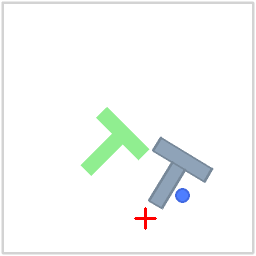

Observ:  array([364.7098, 390.5843, 372.9935, 305.9507,   0.5438])
               [agent_x,  agent_y,  block_x,  block_y,    block_angle]
Action:  array([290.1725, 437.2367]) ⟺ [target_agent_x, target_agent_y]


In [5]:
# 0. create env object
env = PushTEnv()

seed = 500

# 固定全局随机种子
np.random.seed(seed)

# 1. Seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
# env.seed(500)

env.seed(seed)
env.action_space.seed(seed)

# 2. Must reset before starting each episode.
obs, info = env.reset()

# 3. 2D positional action space [0, 512].
action = env.action_space.sample()

# 4. Stepping through environment dynamics with standard OpenAI Gym API.
obs, reward, terminated, truncated, info = env.step(action)

# 5. Render the environment.
img = env.render()  # (256, 256, 3) RGB image
jviz.img(img).html(title='Push-T render after reset').display()

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("Observ: ", repr(obs))
    print("               [agent_x,  agent_y,  block_x,  block_y,    block_angle]")
    print("Action: ", repr(action) + " ⟺ [target_agent_x, target_agent_y]")

## **Demonstration dataset $/$ dataloader**

Defines the `PushTDataset` (a subclass of `torch.utils.data.Dataset`) and helper functions.

The dataset class:
- Load episodes i.e. sequences of (observation, action) tuples from a zarr storage.
- Normalizes each dimension of observation and action to [-1,1].
- Returns: All possible segments of length `pred_horizon`. It also pads the beginning and the end of each episode with repetition, so that each timestep has a fixed number of observation length and action length.
A dictionary is returned with the following signature:
    ```python
    {
        "obs": torch.Tensor of shape (`obs_horizon`, `obs_dim`),
        "action": torch.Tensor of shape (`pred_horizon`, `action_dim`)
    }
    ```

In [6]:
@dataclass
class SequencePointer:
    """
    Container for sample extraction pointers.
    """

    """Starting index in the original data buffer to begin extraction."""
    buffer_start_idx: int

    """Ending index in the original data buffer (exclusive) for extraction."""
    buffer_end_idx: int
    
    """Starting index within the padded sample."""
    sample_start_idx: int
    
    """Ending index within the padded sample."""
    sample_end_idx: int

    def __iter__(self):
        """Allow unpacking: buffer_start, buffer_end, sample_start, sample_end = indices"""
        return iter([self.buffer_start_idx, self.buffer_end_idx, 
                     self.sample_start_idx, self.sample_end_idx])

def create_sequence_pointers(
        episode_ends: np.ndarray, sequence_length: int,
        pad_before: int=0, pad_after: int=0,
    ) -> List[SequencePointer]:
    """
    Create sample indices for extracting sequences from episode data with padding support.
    
    This function generates indices for extracting fixed-length sequences from a dataset
    composed of multiple episodes. It handles padding at the beginning and end of episodes
    to ensure all timesteps can be used as starting points for sequences, even near episode
    boundaries.
    
    Parameters
    ----------
    episode_ends : (np.ndarray, shape=(E,))
        Array containing the end indices (one-past-the-last) for each episode.
        For example, if episodes have lengths [10, 15, 8], then episode_ends = [10, 25, 33].
    sequence_length : int
        Length of the sequences to extract from the dataset.
    pad_before : int, default=0
        Number of timesteps to pad before the episode start. This allows sequences
        to start before the actual episode data by repeating the first values of all data keys.
    pad_after : int, default=0
        Number of timesteps to pad after the episode end. This allows sequences
        to extend beyond the actual episode data by repeating the last values of all data keys.
    
    Returns
    -------
    List[SequencePointer]
        List of SequencePointer objects for extracting sequences from all episodes.
        Can be converted to numpy array using np.array(indices) for compatibility.
        
    Notes
    -----
    The function handles episode boundaries by:
    1. Computing valid start positions for sequences within each episode.
    2. Accounting for padding requirements at episode boundaries.
    3. Returning indices that can be used to extract properly padded sequences.
    
    The returned indices are designed to work with a sampling function that can
    handle the padding by repeating boundary values when accessing out-of-bounds indices.
    
    Example
    -------
    >>> episode_ends = np.array([10, 25, 33])  # 3 episodes of lengths 10, 15, 8
    >>> indices = create_sample_indices(episode_ends, sequence_length=5, pad_before=2, pad_after=1)
    >>> # Returns list of SequencePointer objects for all possible 5-step sequences
    """
    indices = list()
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append(SequencePointer(
                buffer_start_idx,
                buffer_end_idx,
                sample_start_idx,
                sample_end_idx,
            ))
    return indices

def extract_sequence(train_data, sequence_length, ptr: SequencePointer):
    """
    Extract and pad a sequence from training data using specified indices.
    
    This function extracts a sequence from the training data buffer and applies padding
    if necessary to ensure the output has the exact sequence_length. Padding is applied
    by repeating boundary values when the sequence extends beyond the available data.
    
    Parameters
    ----------
    train_data : dict
        Dictionary containing training data arrays. Each key maps to a numpy array
        of shape (N, feature_dim) where N is the total number of timesteps.
        Common keys include 'action' and 'obs' (observations).
    sequence_length : int
        Desired length of the output sequence. All returned arrays will have
        this length in the first dimension.
    ptr : SequencePointer
        Container of sequence pointer indices for extracting and placing the
        sequence data.
    
    Returns
    -------
    dict
        Dictionary with the same keys as train_data, where each value is a numpy array
        of shape (sequence_length, feature_dim). The arrays contain the extracted data
        with appropriate padding applied.
        
    Notes
    -----
    The function handles three cases:
    1. No padding needed: When sample_start_idx=0 and sample_end_idx=sequence_length,
       the extracted data is returned as-is.
    2. Start padding: When sample_start_idx > 0, the first sample_start_idx positions
       are filled with the first value of the extracted sample.
    3. End padding: When sample_end_idx < sequence_length, positions from sample_end_idx
       to sequence_length are filled with the last value of the extracted sample.
    
    This function is typically used with indices generated by create_sample_indices()
    to handle episode boundaries and ensure consistent sequence lengths for training.
    
    Example
    -------
    >>> train_data = {'action': np.array([[1], [2], [3], [4], [5]]), 
    ...               'obs': np.array([[0.1], [0.2], [0.3], [0.4], [0.5]])}
    >>> indices = SampleIndices(buffer_start_idx=1, buffer_end_idx=4,
    ...                         sample_start_idx=2, sample_end_idx=5)
    >>> result = sample_sequence(train_data, sequence_length=6, indices)
    >>> # Extracts [2,3,4] from buffer indices 1:4, but places them at positions 2:5
    >>> # result['action'] = [[2], [2], [2], [3], [4], [4]]  # padded at start and end
    >>> # result['obs'] = [[0.2], [0.2], [0.2], [0.3], [0.4], [0.4]]  # same padding pattern
    """
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[ptr.buffer_start_idx:ptr.buffer_end_idx]
        data = sample
        if (ptr.sample_start_idx > 0) or (ptr.sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if ptr.sample_start_idx > 0:
                data[:ptr.sample_start_idx] = sample[0]
            if ptr.sample_end_idx < sequence_length:
                data[ptr.sample_end_idx:] = sample[-1]
            data[ptr.sample_start_idx:ptr.sample_end_idx] = sample
        result[key] = data
    return result

def get_data_stats(data):
    data = data.reshape(-1,data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])  # to [0, 1]
    ndata = ndata * 2 - 1  # to [-1, 1]
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2  # to [0, 1]
    data = ndata * (stats['max'] - stats['min']) + stats['min']  # to original
    return data

class PushTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path,
                 pred_horizon, obs_horizon, action_horizon):

        # Read from zarr dataset
        dataset_root = zarr.open(dataset_path, 'r')
        
        # All demonstration episodes are concatenated in the first dimension N
        train_data = {
            'action': dataset_root['data']['action'][:],  # (N, action_dim)
            'obs': dataset_root['data']['state'][:],  # (N, obs_dim)
        }
        # Marks one-past the last index for each episode
        episode_ends = dataset_root['meta']['episode_ends'][:]

        # |o|o|                             observations: 2
        # | |a|a|a|a|a|a|a|a|               actions executed: 8
        # |p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

        # Compute start and end of each state-action sequence,
        # also add padding such that each timestep in the dataset is seen
        self.sequence_pointers = create_sequence_pointers(
            episode_ends = episode_ends,
            sequence_length = pred_horizon,
            pad_before = obs_horizon-1,
            pad_after = action_horizon-1,
        )

        # Compute statistics and normalized data to [-1, 1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        """Count of all possible segments of the dataset"""
        return len(self.sequence_pointers)

    def __getitem__(self, idx):
        # Get the sequence pointer for this datapoint
        ptr = self.sequence_pointers[idx]

        # Get normalized data using these indices
        nsample = extract_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            ptr=ptr,
        )

        # discard unused observations
        nsample['obs'] = nsample['obs'][:self.obs_horizon,:]
        return nsample


### `PushTDataset` and dataloaders

In [7]:
# Download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# |o|o|                             observations: 2
# | |a|a|a|a|a|a|a|a|               actions executed: 8
# |p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

pred_horizon = 16
obs_horizon = 2
action_horizon = 8

# Create dataset from file
dataset = PushTDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon,
)
# Save training data statistics (min, max) for each dim
stats = dataset.stats

# Create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    pin_memory=True,  # accelerate cpu-gpu transfer
    persistent_workers=True, # don't kill worker process after each epoch
)

# Visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['obs'].shape: torch.Size([256, 2, 5])
batch['action'].shape torch.Size([256, 16, 2])


## **Neural network architectures**

Defines a 1D UNet architecture `ConditionalUnet1D`
as the noies prediction network

Components:
- `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
- `Downsample1d` Strided convolution to reduce temporal resolution
- `Upsample1d` Transposed convolution to increase temporal resolution
- `Conv1dBlock` Conv1d --> GroupNorm --> Mish
- `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
`x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
`cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.

### Architecture changes in SFP
We are able to **re-use existing diffusion $/$ flow policy architectures** with the following changes:
- Add `scale` parameter to `SinusoidalPosEmb`.
  - <u>*Reason:*</u> Diffusion policy embeds integer diffusion timesteps on the order of 0 to 100, whereas flow policies use a unit interval $[0, 1]$ for time. For compatibility, we scale the unit interval by 100.
- Define the two additional modules `LinearDownsample1d` and `LinearUpsample1d`.
  - <u>*Reason:*</u> Diffusion policy diffuses in the space of action *sequences*, which are processed with 1-D convolutions using `ConvUpsample1d` and `ConvDownsample1d`. However, SFP diffuses in the space of *single actions*. Therefore, we introduce a fully-connected upsampler$/$downsampler that acts on single actions.

In [8]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, scale = 1):
        super().__init__()
        self.dim = dim
        self.scale = scale # added - SFP

    def forward(self, x):
        x = x * self.scale
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ConvDownsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class ConvUpsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

class LinearDownsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)

    def forward(self, x: Tensor):
        # Reshape input to (batch_size, -1) for fully connected layer
        batch_size, channels, seq_len = x.size()
        x = x.view(batch_size, -1)  # flatten spatial dimensions
        x = self.linear(x)
        x = x.view(batch_size, channels, seq_len)  # reshape back to original dimensions
        return x

class LinearUpsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)

    def forward(self, x: Tensor):
        # Reshape input to (batch_size, -1) for fully connected layer
        batch_size, channels, seq_len = x.size()
        x = x.view(batch_size, -1)  # flatten spatial dimensions
        x = self.linear(x)
        x = x.view(batch_size, channels, seq_len)  # reshape back to original dimensions
        return x

class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)

class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8,
                 ):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # Ensure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out

class ConditionalUnet1D (nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        updownsample_type: Literal['Conv', 'Linear'],  # added for SFP
        sin_embedding_scale,  # added for SFP
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8,
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed, scale = sin_embedding_scale), # added - SFP
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            if updownsample_type == 'Linear':  # added for SFP
                downsample_layer = LinearDownsample1d(dim_out) if not is_last else nn.Identity() #added
            elif updownsample_type == 'Conv':
                downsample_layer = ConvDownsample1d(dim_out) if not is_last else nn.Identity()
            else:
                raise ValueError(f"Unsupported updownsample_type: {updownsample_type}")
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                downsample_layer,
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            if updownsample_type == 'Linear':  # added for SFP
                upsample_layer = LinearUpsample1d(dim_in) if not is_last  else nn.Identity()
            elif updownsample_type == 'Conv':
                upsample_layer = ConvUpsample1d(dim_in) if not is_last  else nn.Identity()
            else:
                raise ValueError(f"Unsupported updownsample_type: {updownsample_type}")
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                upsample_layer,
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("Number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: Tensor,
            timestep: Union[Tensor, float, int],
            global_cond=None,
        ) -> Tensor:
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x


### Test neural network

In [9]:
# Observation and action dimensions corresponding to the output of PushTEnv.
obs_horizon = 2
obs_dim = 5
action_dim = 2

# create network object
sfp_velocity_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    # because SFP diffuses over a single action,
    updownsample_type = 'Linear',
    # because the original model assumes timesteps of the order of [0, 100]
    # but SFP uses a time range of [0, 1]
    sin_embedding_scale = 100,
)

# Example inputs
a = torch.randn((1, 1, action_dim)) #changed SFP: action at time t
obs = torch.zeros((1, obs_horizon, obs_dim))
t = torch.zeros((1,))  # changed SFP: time t

# the velocity prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
with torch.no_grad():
    v = sfp_velocity_net(  # changed SFP: predicted velocity at time t
        sample=a,
        timestep=t,
        global_cond=obs.flatten(start_dim=1),
    )

# device transfer
device = torch.device('cuda')
sfp_velocity_net.to(device)

print(f"Predicted velocity shape: {v.shape}")
print(f"Predicted velocity values: {v}")

Number of parameters: 6.371482e+07
Predicted velocity shape: torch.Size([1, 1, 2])
Predicted velocity values: tensor([[[ 0.2035, -0.0741]]])


In [10]:
def LinearlyInterpolateTrajectory(ξ, t):
    """
    Vectorized computation of positions and velocities if each trajectory
    (from a batch of trajectories) at given times for each trajectory, using
    linear interpolation.

    ξ (Tensor, dtype=float, shape=(B, T, A)): batch of action trajectories.
    t (Tensor, dtype=float, shape=(B,)): batch of times in [0, 1].

    Returns:
        ξt   (Tensor, shape=(B, A)): positions at time t
        dξdt (Tensor, shape=(B, A)): velocities at time t
    """
    B, T, A = ξ.shape

    # Compute the lower and upper limits of the bins that the time-points lie in.
    scaled_t = t * (T - 1)  # (B,) lies in [0, T-1]
    l = scaled_t.floor().long().clamp(0, T - 2)  # (B,) lower bin limits
    u = (l + 1).clamp(0, T - 1)  # (B,) upper bin limits
    λ = scaled_t - l.float()  # fractional part, lies in [0, 1]

    # Query the values of the upper and lower bin limits.
    batch_idx = torch.arange(B, device=ξ.device)  # (B,)
    ξl = ξ[batch_idx, l, :]  # (B, A)
    ξu = ξ[batch_idx, u, :]  # (B, A)

    # Linearly interpolate between bin limits to get position.
    λ = λ.unsqueeze(-1)  # (B, 1)
    ξt = ξl + λ * (ξu - ξl)  # (B, A)

    # Compute velocity as first-order hold.
    # Note that the time interval between two bins is Δt = 1 / (T-1).
    dξdt = (ξu - ξl) * (T - 1)  # (B, A)

    return ξt, dξdt  # (B, A) and (B, A)

def SampleCFMInputsAndTargets(ξt, dξdt, t, k, σ0):
    """
    Sample inputs and targets for the conditional flow matching loss (CFM)
    given positions and velocities at time t.

    This functions performs the following sampling (Eq. 2 and 3 of the paper):
        a ~ N(ξ(t), σ₀² exp(-2kt))  # (Eq. 3 in the paper)
        v = -k (a - ξ(t)) + dξdt(t)  # (Eq. 2 in the paper)

    Args:
        ξt (Tensor, shape=(B, A)): positions at time t.
        dξdt (Tensor, shape=(B, A)): velocities at time t.
        t (Tensor, shape=(B,)): times in [0, 1].
        k (float): Stabilizing gains of the conditional flow.
        σ0 (float): initial standard deviation of the noise added to the action.

    Returns:
        a (Tensor, shape=(B, A)): noised actions at time t
        v (Tensor, shape=(B, A)): noised action velocity targets at time t
    """
    # error = σ0 * torch.exp(-k*t).unsqueeze(1) * torch.randn_like(xt)
    t = t.unsqueeze(-1)  # (B, 1)
    sampled_error = σ0 * torch.exp(-k * t) * torch.randn_like(ξt)  # (B, A)
    a = ξt + sampled_error  # (B, A) ⟸ Eq. 3 in the paper
    v = -k * sampled_error + dξdt  # (B, A) ⟸ Eq. 2 in the paper

    return a, v  # (B, A) and (B, A)

### Streaming stochastic interpolant policy: Training, Inference, and Guidance!

In [12]:
# =========================================================
# 1. 辅助函数: Gamma 调度器 (参考 model.py)
# =========================================================
EPS = 1e-6

def gamma_t_si(t):
    # 使用简单的抛物线/气泡形状，在 t=0 和 t=1 时为 0，中间膨胀
    # 这里的系数 0.1 控制 "SI 气泡" 的大小，相对于 SFP 的管状噪声
    return 0.1 * torch.sqrt(t * (1.0 - t) + EPS)

def d_gamma_dt_si(t):
    # gamma(t) 对 t 的导数
    return 0.1 * (1.0 - 2.0 * t) / (2.0 * torch.sqrt(t * (1.0 - t) + EPS))

# =========================================================
# 2. 初始化模型 (VelocityNet 和 DenoiserNet)
# =========================================================
# SFP 参数
obs_horizon = 2
obs_dim = 5
action_dim = 2
pred_horizon = 16

# 我们需要两个网络：
# 1. si_velocity_net: 预测确定性速度场 (v)
# 2. si_denoiser_net: 预测噪声场 (eta/score)

si_velocity_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    updownsample_type='Linear',
    sin_embedding_scale=100,
).to(device)

si_denoiser_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    updownsample_type='Linear',
    sin_embedding_scale=100,
).to(device)

print("Models initialized for Streaming SI Policy.")

# =========================================================
# 3. 优化器设置
# =========================================================
optimizer_si = torch.optim.AdamW([
    {'params': si_velocity_net.parameters()},
    {'params': si_denoiser_net.parameters()}
], lr=1e-4, weight_decay=1e-6)

# EMA (Exponential Moving Average) for better inference stability
ema_si_v = EMAModel(parameters=si_velocity_net.parameters(), power=0.75)
ema_si_eta = EMAModel(parameters=si_denoiser_net.parameters(), power=0.75)

num_epochs_si = 100
lr_scheduler_si = get_scheduler(
    name='cosine',
    optimizer=optimizer_si,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs_si
)

Number of parameters: 6.371482e+07
Number of parameters: 6.371482e+07
Models initialized for Streaming SI Policy.


In [13]:
# # =========================================================
# # 训练循环: Conditional Streaming SI Policy
# # =========================================================
# sigma0 = 0.4  # SFP 初始管状半径
# k = 10.0      # SFP 稳定系数

# print("Starting training for Streaming SI Policy...")

# with tqdm(range(num_epochs_si), desc='Epoch') as tglobal:
#     for epoch_idx in tglobal:
#         epoch_loss = []
#         with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
#             for nbatch in tepoch:
#                 # 1. 数据准备
#                 nobs = nbatch['obs'].to(device)
#                 naction = nbatch['action'].to(device)
                
#                 # 提取当前及未来的动作片段
#                 ξ = naction[:, obs_horizon-1:, :] 
#                 B = ξ.shape[0]
                
#                 # 随机采样时间 t ~ U[0, 1]
#                 t = torch.rand(B, device=device)
                
#                 # 2. 计算 Ground Truth 位置和速度 (Linearly Interpolate)
#                 ξt, dξdt = LinearlyInterpolateTrajectory(ξ, t)
                
#                 # 3. 构建 Flow Matching (FP) 基础目标 (管状分布)
#                 # a_t_fp = ξ(t) + σ(t) * ε1
#                 # 这里的 σ(t) = σ0 * exp(-kt)
#                 t_expanded = t.view(B, 1)
#                 sigma_t_fp = sigma0 * torch.exp(-k * t_expanded)
#                 noise_fp = torch.randn_like(ξt)
#                 a_t_fp = ξt + sigma_t_fp * noise_fp
                
#                 # 计算 Velocity Target (指向轨迹的向量场)
#                 # v_target = dξ/dt - k * (a_t_fp - ξ(t))
#                 # 注意：这个速度是定义在 a_t_fp 上的
#                 v_target = dξdt - k * (a_t_fp - ξt)
                
#                 # 4. 构建 Stochastic Interpolant (SI) 扰动
#                 # x_t = a_t_fp + γ(t) * z
#                 # 我们在 SFP 的管子外面再套一层 SI 的气泡
#                 gamma = gamma_t_si(t_expanded)
#                 z_noise_si = torch.randn_like(ξt)
#                 x_t_in_s = a_t_fp + gamma * z_noise_si
                
#                 # 5. 网络前向传播
#                 # 输入需要 reshape 成 (B, 1, A) 以适应 UNet 接口
#                 net_input = x_t_in_s.unsqueeze(1)
#                 global_cond = nobs.flatten(start_dim=1)
                
#                 # 预测速度
#                 v_pred = si_velocity_net(sample=net_input, timestep=t, global_cond=global_cond)
#                 v_pred = v_pred.squeeze(1)
                
#                 # 预测噪声 (Score 相关的量)
#                 eta_pred = si_denoiser_net(sample=net_input, timestep=t, global_cond=global_cond)
#                 eta_pred = eta_pred.squeeze(1)
                
#                 # 6. 计算 Loss
#                 # 这里的关键是：虽然输入是 x_t_in_s (更宽的分布)，
#                 # 但 VelocityNet 学习的是原本 SFP 层的速度场 v_target，
#                 # DenoiserNet 学习的是新增的噪声 z_noise_si。
#                 loss_v = nn.functional.mse_loss(v_pred, v_target)
#                 loss_eta = nn.functional.mse_loss(eta_pred, z_noise_si)
                
#                 loss = loss_v + loss_eta
                
#                 # 7. 反向传播
#                 loss.backward()
#                 optimizer_si.step()
#                 optimizer_si.zero_grad()
#                 lr_scheduler_si.step()
                
#                 # 更新 EMA
#                 ema_si_v.step(si_velocity_net.parameters())
#                 ema_si_eta.step(si_denoiser_net.parameters())
                
#                 epoch_loss.append(loss.item())
#                 tepoch.set_postfix(loss=loss.item(), v_loss=loss_v.item())
                
#         tglobal.set_postfix(loss=np.mean(epoch_loss))

# # 保存模型
# ckpt_path_si = "pusht_state_100ep_si.ckpt"
# torch.save({
#     'velocity_net': si_velocity_net.state_dict(),
#     'denoiser_net': si_denoiser_net.state_dict()
# }, ckpt_path_si)
# print(f"Saved Streaming SI model to {ckpt_path_si}")

# # 准备推理用的 EMA 模型
# ema_si_velocity_net = si_velocity_net
# ema_si_denoiser_net = si_denoiser_net
# ema_si_v.copy_to(ema_si_velocity_net.parameters())
# ema_si_eta.copy_to(ema_si_denoiser_net.parameters())

In [14]:
# =========================================================
# 加载预训练的 Streaming SI Policy 模型 (跳过训练)
# =========================================================

load_pretrained = True
ckpt_path_si = "pusht_state_100ep_si.ckpt"

# 检查文件是否存在
if load_pretrained and os.path.isfile(ckpt_path_si):
    print(f"Found pretrained checkpoint: {ckpt_path_si}")
    checkpoint = torch.load(ckpt_path_si, map_location=device)

    # 1. 加载权重到基础网络
    si_velocity_net.load_state_dict(checkpoint['velocity_net'])
    si_denoiser_net.load_state_dict(checkpoint['denoiser_net'])

    # 2. 设置推理用的模型
    # 在跳过训练的情况下，我们将直接使用加载的权重作为推理模型
    # (模拟 EMA 模型及其接口)
    ema_si_velocity_net = si_velocity_net
    ema_si_denoiser_net = si_denoiser_net

    print('Pretrained weights loaded for Streaming SI Policy. Ready for inference!')

else:
    print(f"Checkpoint {ckpt_path_si} not found. Please run the training cell below.")
    # 如果需要，这里可以初始化 EMA 模型容器，以便后续训练使用
    # ema_si_velocity_net = ... (通常在训练循环中通过 EMAModel 初始化)

Found pretrained checkpoint: pusht_state_100ep_si.ckpt
Pretrained weights loaded for Streaming SI Policy. Ready for inference!


Running Inference: Streaming SI (ODE Mode) (sigma=0.0)
Score: 0.9767403092068762



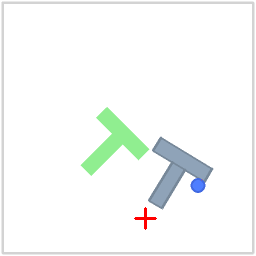

Running Inference: Streaming SI (SDE Mode) (sigma=0.05)
Score: 0.956150720497358



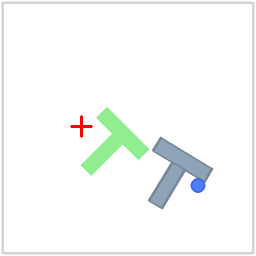

In [15]:
# =========================================================
# 辅助函数: 计算 Drift (Doob's h-transform)
# =========================================================
def get_drift(x, t, global_cond, sigma_infer, eps=1e-6):
    """
    计算修正后的漂移项 b(x, t)
    参考 model.py: b = v_pred + score_coeff * s_pred
    """
    # 确保 t 的维度 (B,)
    if t.ndim == 0: t = t.unsqueeze(0)
    
    # 预测 v 和 eta
    # x shape: (B, 1, A)
    v_pred = ema_si_velocity_net(sample=x, timestep=t, global_cond=global_cond)
    eta_pred = ema_si_denoiser_net(sample=x, timestep=t, global_cond=global_cond)
    
    # 计算系数
    gamma = gamma_t_si(t).view(-1, 1, 1).to(device)
    gamma_dot = d_gamma_dt_si(t).view(-1, 1, 1).to(device)
    
    # Score prediction s = -eta / (gamma + eps)
    s_pred = -eta_pred / (gamma + eps)
    
    # Score coefficient = 0.5 * sigma_infer^2 - gamma * gamma_dot
    score_coeff = 0.5 * (sigma_infer ** 2) - (gamma * gamma_dot)
    
    # 最终漂移 b
    b = v_pred + score_coeff * s_pred
    return b

# =========================================================
# 推理演示函数 (已修复 dtype 问题)
# =========================================================
def run_si_inference(sigma_infer, title):
    obs, info = env.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    imgs = [env.render()]
    rewards = []
    
    # 初始化动作 (Warm start)
    a = obs[:action_dim]
    na = normalize_data(a, stats=stats['action'])
    # 确保 na 是 float32
    na = torch.from_numpy(na).to(device, dtype=torch.float32)
    # (B, 1, A)
    na_from_prev_chunk = na.unsqueeze(0).unsqueeze(0)
    
    done = False
    step_idx = 0
    max_steps = 200
    
    # 积分步长
    dt_val = 1.0 / (pred_horizon - obs_horizon)
    
    print(f"Running Inference: {title} (sigma={sigma_infer})")
    
    with torch.no_grad():
        while not done and step_idx < max_steps:
            # 准备观测
            obs = np.stack(obs_deque)
            nobs = normalize_data(obs, stats=stats['obs'])
            # 确保 o_test 是 float32
            o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
            
            na = na_from_prev_chunk
            
            # Streaming Loop
            for i in range(action_horizon):
                # 1. 执行当前动作
                a_cpu = na.detach().to('cpu').numpy().squeeze()
                a_real = unnormalize_data(a_cpu, stats=stats['action'])
                obs, reward, done, _, info = env.step(a_real)
                
                obs_deque.append(obs)
                rewards.append(reward)
                imgs.append(env.render())
                
                step_idx += 1
                if done or step_idx >= max_steps: break
                
                # 2. 积分计算下一步 (Euler-Maruyama)
                t_scalar = i * dt_val
                # 避免 t=0 或 t=1 附近的数值不稳定
                t_scalar = np.clip(t_scalar, 1e-3, 1.0 - 1e-3)
                
                # [关键修复] 强制指定 dtype=torch.float32
                t = torch.tensor([t_scalar], device=device, dtype=torch.float32)
                
                # 计算漂移项
                b_drift = get_drift(na, t, o_test, sigma_infer)
                
                # 计算扩散项 (Langevin Noise)
                # diffusion = sigma_infer * sqrt(dt) * noise
                noise = torch.randn_like(na)
                diffusion = sigma_infer * math.sqrt(dt_val) * noise
                
                # 更新动作
                na = na + b_drift * dt_val + diffusion
            
            na_from_prev_chunk = na
            if done: break

    print(f"Score: {max(rewards)}")
    return imgs

# =========================================================
# 1. 展示 ODE 模式 (sigma_infer = 0)
# =========================================================
# 这应该产生非常平滑、确定性的轨迹
imgs_ode = run_si_inference(sigma_infer=0.0, title="Streaming SI (ODE Mode)")
jviz.gif(imgs_ode, time_in_ms=len(imgs_ode)*50, hold_last_frame_time_in_ms=1000)\
    .html(width=256, pixelated=False, title="SI Policy (ODE, Sigma=0)").display()

# =========================================================
# 2. 展示 SDE 模式 (sigma_infer = 0.2)
# =========================================================
# 这引入了随机性，有助于探索或处理多模态，类似于 Diffusion
imgs_sde = run_si_inference(sigma_infer=0.05, title="Streaming SI (SDE Mode)")
jviz.gif(imgs_sde, time_in_ms=len(imgs_sde)*50, hold_last_frame_time_in_ms=1000)\
    .html(width=256, pixelated=False, title="SI Policy (SDE, Sigma=0.05)").display()

Running Inference: Streaming SI (ODE Mode) (sigma=0.0)
Score: 0.9767403092068762



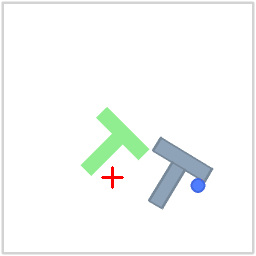

Running Inference: Streaming SI (SDE Mode) (sigma=0.05)
Score: 0.9833169246370773



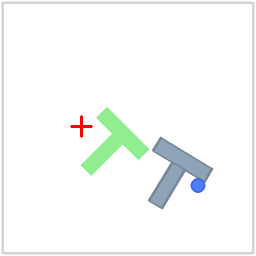

In [16]:
import cv2  # 引入opencv用于绘制文字和图形

# ... (get_drift 函数保持不变，省略以节省空间) ...

# =========================================================
# 推理演示函数 (仅修改可视化部分)
# =========================================================
def run_si_inference(sigma_infer, title):
    obs, info = env.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    imgs = [env.render()]
    rewards = []
    
    # 初始化动作 (Warm start)
    a = obs[:action_dim]
    na = normalize_data(a, stats=stats['action'])
    # 确保 na 是 float32
    na = torch.from_numpy(na).to(device, dtype=torch.float32)
    # (B, 1, A)
    na_from_prev_chunk = na.unsqueeze(0).unsqueeze(0)
    
    done = False
    step_idx = 0
    max_steps = 200
    
    # 积分步长
    dt_val = 1.0 / (pred_horizon - obs_horizon)
    
    print(f"Running Inference: {title} (sigma={sigma_infer})")
    
    with torch.no_grad():
        while not done and step_idx < max_steps:
            # 准备观测 (这里的 History 更新只在外层循环生效一次)
            obs = np.stack(obs_deque)
            nobs = normalize_data(obs, stats=stats['obs'])
            # 确保 o_test 是 float32
            o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
            
            na = na_from_prev_chunk
            
            # Streaming Loop
            for i in range(action_horizon):
                # 1. 执行当前动作
                a_cpu = na.detach().to('cpu').numpy().squeeze()
                a_real = unnormalize_data(a_cpu, stats=stats['action'])
                obs, reward, done, _, info = env.step(a_real)
                
                obs_deque.append(obs)
                rewards.append(reward)
                
                # ================= [开始] 可视化修改区域 =================
                # 获取原始图像
                img = env.render().copy() # copy 防止修改原内存
                
                # 积分时间 t
                t_scalar_disp = i * dt_val
                
                # 绘制基础信息 (左上角)
                cv2.putText(img, f"Step: {step_idx} | t: {t_scalar_disp:.2f}", (10, 20), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

                # 绘制状态指示
                if i == 0:
                    # >>> 这一帧是重新调用模型、读取新History的时刻 <<<
                    # 画个绿色边框
                    cv2.rectangle(img, (0, 0), (256, 256), (0, 255, 0), 4)
                    # 写大字提示
                    cv2.putText(img, "[MODEL RE-PLANNING]", (10, 240), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                else:
                    # >>> 这一帧是在执行之前算好的轨迹 (Chunking) <<<
                    cv2.putText(img, f"Exec Chunk: {i}/{action_horizon}", (10, 240), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200, 200, 200), 1)
                
                imgs.append(img)
                # ================= [结束] 可视化修改区域 =================
                
                step_idx += 1
                if done or step_idx >= max_steps: break
                
                # 2. 积分计算下一步 (Euler-Maruyama)
                t_scalar = i * dt_val
                # 避免 t=0 或 t=1 附近的数值不稳定
                t_scalar = np.clip(t_scalar, 1e-3, 1.0 - 1e-3)
                
                # [关键修复] 强制指定 dtype=torch.float32
                t = torch.tensor([t_scalar], device=device, dtype=torch.float32)
                
                # 计算漂移项
                b_drift = get_drift(na, t, o_test, sigma_infer)
                
                # 计算扩散项 (Langevin Noise)
                # diffusion = sigma_infer * sqrt(dt) * noise
                noise = torch.randn_like(na)
                diffusion = sigma_infer * math.sqrt(dt_val) * noise
                
                # 更新动作
                na = na + b_drift * dt_val + diffusion
            
            na_from_prev_chunk = na
            if done: break

    print(f"Score: {max(rewards)}")
    return imgs

# =========================================================
# 1. 展示 ODE 模式 (sigma_infer = 0)
# =========================================================
# 这应该产生非常平滑、确定性的轨迹
imgs_ode = run_si_inference(sigma_infer=0.0, title="Streaming SI (ODE Mode)")
jviz.gif(imgs_ode, time_in_ms=len(imgs_ode)*50, hold_last_frame_time_in_ms=1000)\
    .html(width=256, pixelated=False, title="SI Policy (ODE, Sigma=0)").display()

# =========================================================
# 2. 展示 SDE 模式 (sigma_infer = 0.2)
# =========================================================
# 这引入了随机性，有助于探索或处理多模态，类似于 Diffusion
imgs_sde = run_si_inference(sigma_infer=0.05, title="Streaming SI (SDE Mode)")
jviz.gif(imgs_sde, time_in_ms=len(imgs_sde)*50, hold_last_frame_time_in_ms=1000)\
    .html(width=256, pixelated=False, title="SI Policy (SDE, Sigma=0.05)").display()

## CCG

In [17]:
# 重新定义 dataloader，强制使用主进程 (num_workers=0)
# 这能解决 "Worker exited unexpectedly" 错误
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=0,            # [关键修改] 改为 0，在此 notebook 环境中最稳定
    shuffle=True,
    pin_memory=True,
    persistent_workers=False  # [关键修改] num_workers=0 时必须设为 False
)

print("✅ DataLoader has been reset to single-process mode.")

✅ DataLoader has been reset to single-process mode.


#### Critic Training

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

# 检测设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Add the specific numpy scalar to the allowed list
torch.serialization.add_safe_globals([np._core.multiarray.scalar])
torch.serialization.add_safe_globals([
    np.dtype, 
    np._core.multiarray.scalar, 
    np._core.multiarray._reconstruct
])

# =========================================================
# 1. 网络架构定义 (High Capacity ResNet Critic)
# =========================================================

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.Mish(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.Mish()
        )
        
    def forward(self, x):
        return x + self.net(x)

class CollisionPredictionCritic(nn.Module):
    def __init__(self, action_dim, obs_dim, obs_horizon, hidden_dim=1024, depth=6):
        super().__init__()
        self.obs_dim = obs_dim
        # context_encoder 使用卷积提取时间序列特征
        self.context_encoder = nn.Sequential(
            nn.Conv1d(obs_dim, 256, kernel_size=3, padding=1),
            nn.Mish(),
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.Mish(),
            nn.AdaptiveAvgPool1d(1), 
            nn.Flatten()             
        )
        # 几何编码器输入: [a(2), t(1), obs(2), rel_vec(2), dist(1), alignment(1)] = 9
        self.geo_encoder = nn.Sequential(
            nn.Linear(9, 512),
            nn.Mish(),
            nn.LayerNorm(512)
        )
        self.fusion = nn.Linear(512 + 512, hidden_dim)
        self.blocks = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(depth)])
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 4),
            nn.Mish(),
            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid()
        )

    def forward(self, a, t, obs_pos, global_cond):
        B = a.shape[0]
        if t.dim() == 1: t = t.unsqueeze(-1)
        
        # 自动推算序列长度，防止维度报错
        total_elements = global_cond.numel()
        seq_len = (total_elements // B) // self.obs_dim
        
        # 1. 上下文编码
        ctx = global_cond.view(B, seq_len, self.obs_dim).transpose(1, 2)
        ctx_feat = self.context_encoder(ctx)

        # 2. 几何特征构造
        rel_vec = obs_pos - a
        dist = torch.norm(rel_vec, dim=-1, keepdim=True)
        a_norm = a / (torch.norm(a, dim=-1, keepdim=True) + 1e-7)
        obs_dir = rel_vec / (dist + 1e-7)
        alignment = (a_norm * obs_dir).sum(dim=-1, keepdim=True)
        
        geo_in = torch.cat([a, t, obs_pos, rel_vec, dist, alignment], dim=-1)
        geo_feat = self.geo_encoder(geo_in)

        # 3. 融合与残差推理
        x = torch.cat([ctx_feat, geo_feat], dim=-1)
        x = self.fusion(x)
        for block in self.blocks:
            x = block(x)
        return self.head(x)

# =========================================================
# 2. 风险评估逻辑 (Labeling Function)
# =========================================================

def compute_hybrid_risk(trajectory, obs_pos, r_obs=0.02, sharpness=60.0):
    # trajectory: (Steps, Total_B, 2), obs_pos: (Total_B, 2)
    dists = torch.norm(trajectory - obs_pos.unsqueeze(0), p=2, dim=-1)
    min_dist = torch.min(dists, dim=0)[0] 
    prob_hit = torch.sigmoid(sharpness * (r_obs + 0.02 - min_dist))
    
    start_pos = trajectory[0]
    future_idx = min(5, trajectory.shape[0]-1)
    future_pos = trajectory[future_idx] 
    vec_move = future_pos - start_pos
    dist_move = torch.norm(vec_move, p=2, dim=-1) + 1e-7
    dir_move = vec_move / dist_move.unsqueeze(-1)
    
    vec_to_obs = obs_pos - start_pos
    dist_to_obs = torch.norm(vec_to_obs, p=2, dim=-1) + 1e-7
    dir_to_obs = vec_to_obs / dist_to_obs.unsqueeze(-1)
    
    alignment = torch.relu((dir_move * dir_to_obs).sum(dim=-1))
    dist_factor = torch.exp(-(dist_to_obs**2) / (2 * 0.8**2))
    prob_aim = (alignment ** 2) * dist_factor
    return torch.maximum(prob_hit, 0.6 * prob_aim)

# =========================================================
# 3. 核心训练函数 (含恢复逻辑)
# =========================================================

def train_robust_critic(dataloader, si_velocity_net, action_dim, obs_dim, obs_horizon, 
                        epochs=150, K_samples=12, sample_t_max=0.8, save_path="Robust_critic_3.pth"):
    
    print(f"--- Initialization ---")
    checkpoint_path = save_path.replace(".pth", "_latest_checkpoint.pth")
    best_model_path = save_path.replace(".pth", "_best.pth")
    
    critic = CollisionPredictionCritic(action_dim, obs_dim, obs_horizon, hidden_dim=1024, depth=6).to(device)
    optimizer = torch.optim.AdamW(critic.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    loss_fn = nn.MSELoss()
    
    start_epoch = 0
    best_loss = float('inf')
    dt = 1.0 / 16.0

    # 加载断点
    if os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
        critic.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        start_epoch = ckpt['epoch'] + 1
        best_loss = ckpt.get('best_loss', float('inf'))
        print(f"Restarting at Epoch {start_epoch+1}")

    def get_drift(a, t, cond):
        t_in = torch.clamp(t, 0.02, 0.98).view(-1)
        v = si_velocity_net(a.unsqueeze(1), t_in, cond).squeeze(1)
        return v

    for epoch in range(start_epoch, epochs):
        epoch_losses = []
        critic.train()
        
        with tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', leave=False) as pbar:
            for batch in pbar:
                obs = batch['obs'].to(device)
                gt_action = batch['action'].to(device)
                B = obs.shape[0]
                global_cond = obs.flatten(start_dim=1)
                
                # A. 动态生成障碍物
                with torch.no_grad():
                    t_start = torch.rand(B, 1, device=device) * sample_t_max
                    target_idx = torch.clamp((obs_horizon-1 + (t_start*16).long()), max=gt_action.shape[1]-1)
                    a_base = torch.gather(gt_action, 1, target_idx.unsqueeze(-1).expand(-1,-1,2)).squeeze(1)

                    curr_a, curr_t, path = a_base.clone(), t_start.clone().view(-1), [a_base.clone()]
                    for _ in range(8):
                        v = get_drift(curr_a, curr_t, global_cond)
                        curr_a += v * dt * (curr_t < 0.98).float().unsqueeze(1)
                        curr_t += dt
                        path.append(curr_a.clone())
                    
                    path_tensor = torch.stack(path, dim=0)
                    base_obs = path_tensor[torch.randint(0,9,(B,)), torch.arange(B)]
                    final_obs = torch.clamp(base_obs + torch.randn_like(base_obs)*0.15, -0.95, 0.95)

                # B. 构造多样化动作
                n_pert = 6
                perp = torch.stack([-(path_tensor[-1,:,1]-path_tensor[0,:,1]), path_tensor[-1,:,0]-path_tensor[0,:,0]], dim=1)
                a_list = [a_base, a_base+torch.randn_like(a_base)*0.1, a_base+torch.randn_like(a_base)*0.25, 
                          a_base+perp*0.2, a_base-perp*0.2, a_base+torch.randn_like(a_base)*0.5]
                
                a_exp = torch.stack(a_list, dim=1).view(-1, 2)
                cond_exp = global_cond.repeat_interleave(n_pert, dim=0)
                t_exp = t_start.repeat_interleave(n_pert, dim=0)
                obs_exp = final_obs.repeat_interleave(n_pert, dim=0)

                # C. Rollout 采样风险标签
                curr_a_k = a_exp.repeat_interleave(K_samples, dim=0)
                curr_t_k = t_exp.repeat_interleave(K_samples, dim=0).view(-1)
                curr_cond_k = cond_exp.repeat_interleave(K_samples, dim=0)
                
                traj = [curr_a_k.clone()]
                with torch.no_grad():
                    for _ in range(12):
                        v = get_drift(curr_a_k, curr_t_k, curr_cond_k)
                        curr_a_k += (v*dt + 0.05*math.sqrt(dt)*torch.randn_like(curr_a_k)) * (curr_t_k < 0.99).float().unsqueeze(1)
                        curr_t_k += dt
                        traj.append(curr_a_k.clone())
                
                target_risk = compute_hybrid_risk(torch.stack(traj, dim=0), obs_exp.repeat_interleave(K_samples, dim=0))
                target_risk = target_risk.view(B * n_pert, K_samples).mean(dim=1, keepdim=True)

                # D. 训练步
                pred_risk = critic(a_exp, t_exp, obs_exp, cond_exp)
                loss = loss_fn(pred_risk, target_risk)
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(critic.parameters(), 1.0)
                optimizer.step()
                
                epoch_losses.append(loss.item())
                pbar.set_postfix(loss=f"{loss.item():.5f}")

        # E. 存储逻辑
        scheduler.step()
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.7f}")

        # 保存断点
        ckpt = {
            'epoch': epoch, 'model_state_dict': critic.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(), 'best_loss': best_loss
        }
        torch.save(ckpt, checkpoint_path)

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(critic.state_dict(), best_model_path)
            print("Successfully saved best model.")

        if (epoch + 1) % 20 == 0:
            torch.save(critic.state_dict(), save_path.replace(".pth", f"_ep{epoch+1}.pth"))

    torch.save(critic.state_dict(), save_path)
    return critic
# =========================================================
# 调用示例:
trained_model = train_robust_critic(dataloader, si_velocity_net, action_dim=2, obs_dim=5, obs_horizon=2)

--- Initialization ---
Resuming from checkpoint: Robust_critic_3_latest_checkpoint.pth
Restarting at Epoch 87


Epoch 87/150:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 87 | Loss: 0.007856 | LR: 0.0000376


Epoch 88/150:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 88 | Loss: 0.007709 | LR: 0.0000366
Successfully saved best model.


Epoch 89/150:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 89 | Loss: 0.007728 | LR: 0.0000355


Epoch 90/150:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 90 | Loss: 0.007749 | LR: 0.0000345


Epoch 91/150:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 91 | Loss: 0.007664 | LR: 0.0000336
Successfully saved best model.


Epoch 92/150:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 92 | Loss: 0.007604 | LR: 0.0000326
Successfully saved best model.


Epoch 93/150:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 93 | Loss: 0.007538 | LR: 0.0000316
Successfully saved best model.


Epoch 94/150:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 94 | Loss: 0.007525 | LR: 0.0000306
Successfully saved best model.


Epoch 95/150:   0%|          | 0/95 [00:00<?, ?it/s]

#### Visualize_newwww

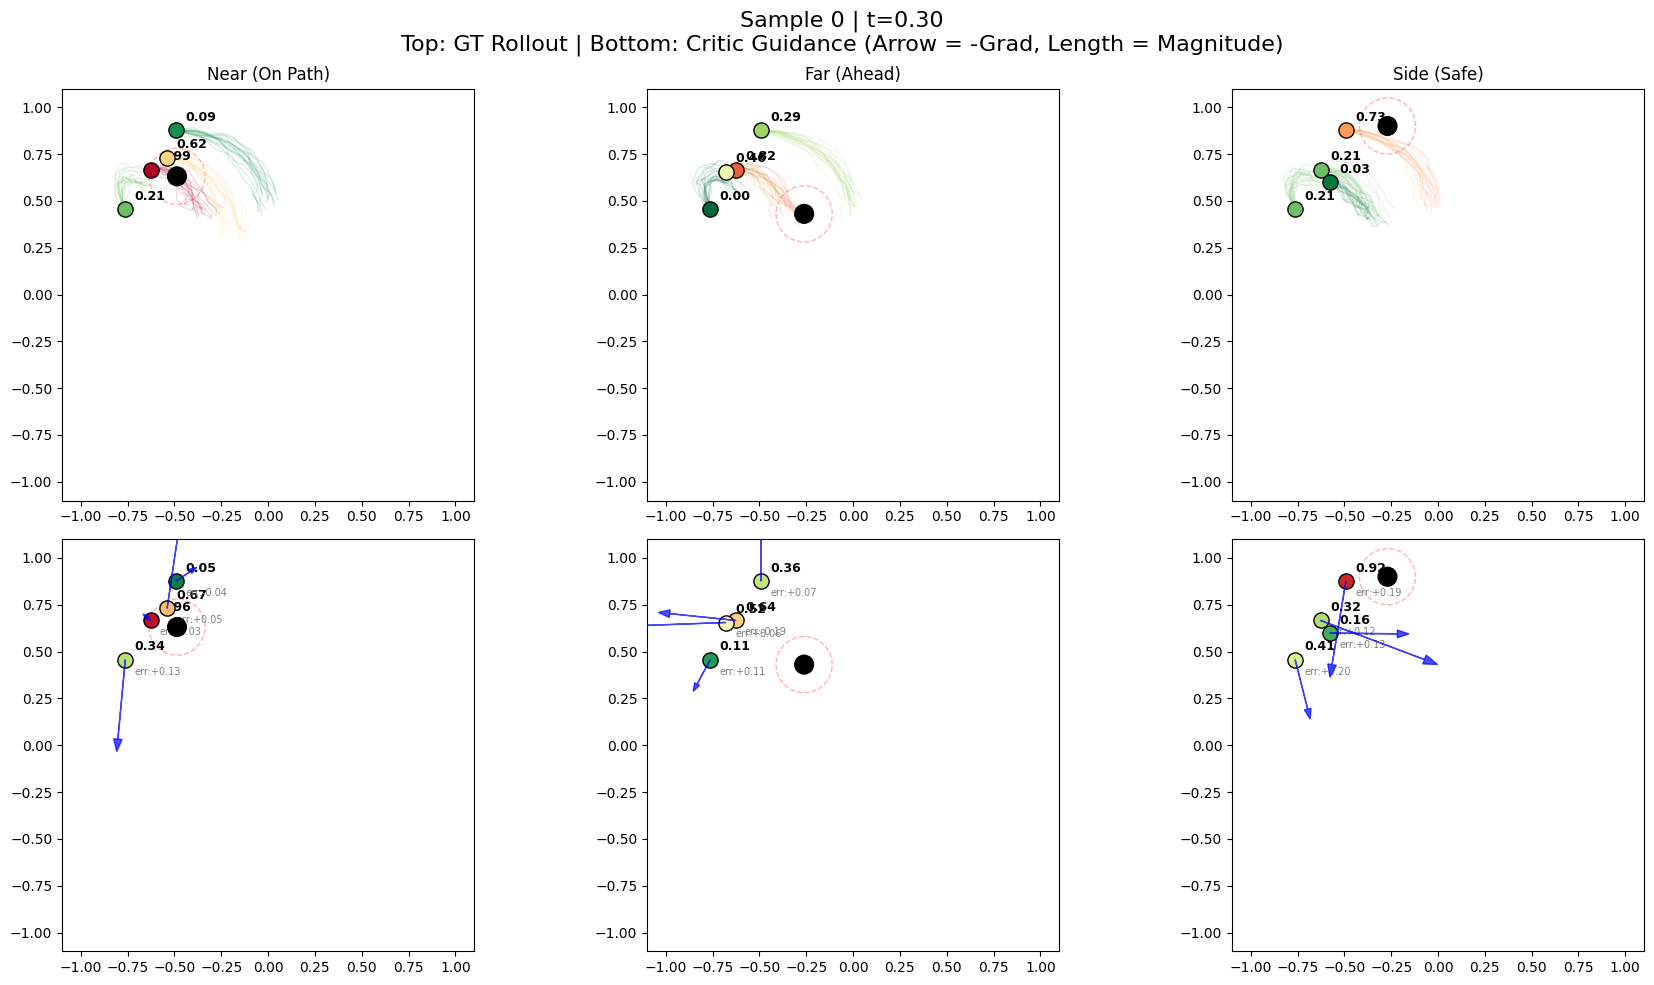

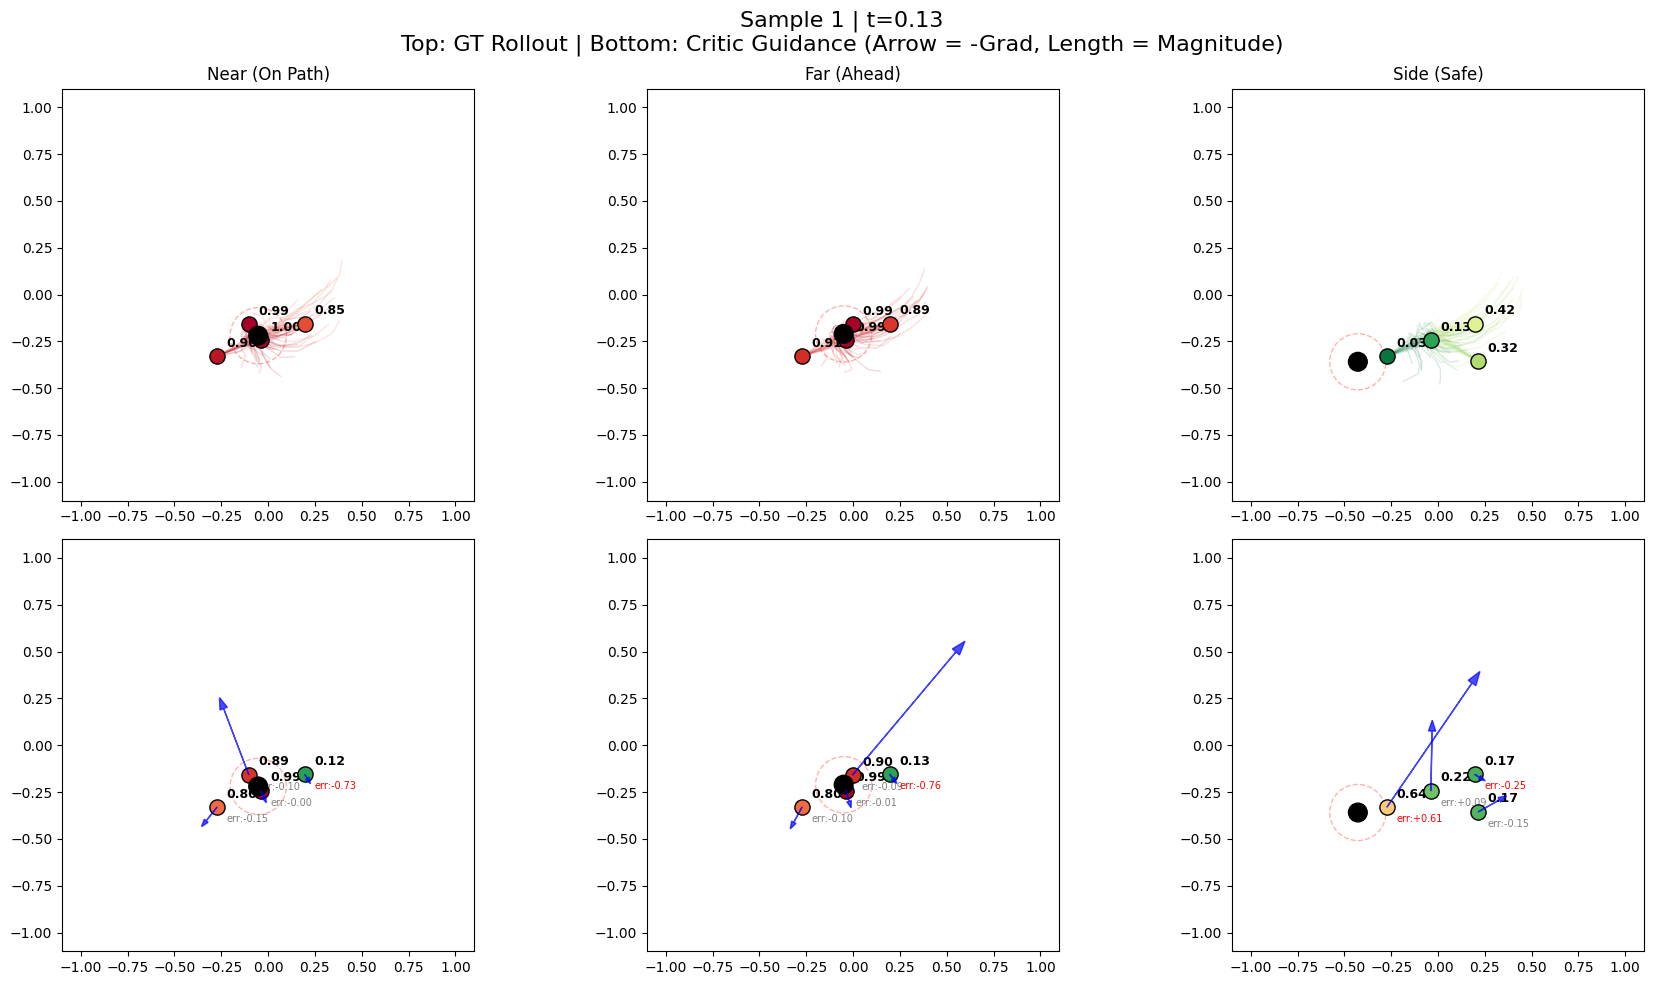

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

# =========================================================
# 1. 风险计算逻辑 (保持不变)
# =========================================================
def compute_hybrid_risk(trajectory, obs_pos, r_obs=0.05, sharpness=60.0):
    dists = torch.norm(trajectory - obs_pos.unsqueeze(0), p=2, dim=-1)
    min_dist = torch.min(dists, dim=0)[0] 
    prob_hit = torch.sigmoid(sharpness * (r_obs + 0.05 - min_dist))
    
    start_pos = trajectory[0] 
    future_idx = min(5, trajectory.shape[0]-1)
    future_pos = trajectory[future_idx] 
    
    vec_move = future_pos - start_pos
    dist_move = torch.norm(vec_move, p=2, dim=-1) + 1e-7
    dir_move = vec_move / dist_move.unsqueeze(-1)
    
    vec_to_obs = obs_pos - start_pos
    dist_to_obs = torch.norm(vec_to_obs, p=2, dim=-1) + 1e-7
    dir_to_obs = vec_to_obs / dist_to_obs.unsqueeze(-1)
    
    alignment = torch.relu((dir_move * dir_to_obs).sum(dim=-1))
    dist_factor = torch.exp(-(dist_to_obs**2) / (2 * 0.8**2))
    prob_aim = (alignment ** 2) * dist_factor
    
    return torch.maximum(prob_hit, 0.6 * prob_aim)

# =========================================================
# 2. 核心可视化函数 (已修改箭头逻辑)
# =========================================================
def visualize_critic_diagnostic(dataloader, si_velocity_net, critic_net, 
                                obs_horizon=2, num_vis=2, K_samples=16):
    critic_net.eval()
    si_velocity_net.eval()
    device = next(critic_net.parameters()).device
    
    dt = 1.0 / 16.0
    iter_loader = iter(dataloader)
    batch = next(iter_loader)
    
    obs = batch['obs'].to(device)
    gt_action = batch['action'].to(device)
    B = obs.shape[0]
    global_cond = obs.flatten(start_dim=1)
    
    num_vis = min(num_vis, B)

    def get_drift(a, t, cond):
        t_in = torch.clamp(t, 0.02, 0.98).view(-1)
        v = si_velocity_net(a.unsqueeze(1), t_in, cond).squeeze(1)
        return v

    for i in range(num_vis):
        t_val = torch.rand(1, device=device) * 0.4 
        start_idx = obs_horizon - 1
        step_offset = int(t_val.item() * 16)
        target_idx = min(start_idx + step_offset, gt_action.shape[1]-1)
        
        a_base = gt_action[i, target_idx].unsqueeze(0) 
        cond_i = global_cond[i].unsqueeze(0)
        
        # 预测参考路径
        curr_a, curr_t, path = a_base.clone(), t_val.clone().view(-1), [a_base.clone()]
        with torch.no_grad():
            for _ in range(8):
                v = get_drift(curr_a, curr_t, cond_i)
                curr_a += v * dt
                curr_t += dt
                path.append(curr_a.clone())
        path_tensor = torch.stack(path, dim=0).squeeze(1)
        
        move_vec = path_tensor[-1] - path_tensor[0]
        perp_vec = torch.tensor([-move_vec[1], move_vec[0]], device=device)
        perp_vec = perp_vec / (torch.norm(perp_vec) + 1e-7)

        scenarios = [
            ("Near (On Path)", path_tensor[len(path_tensor)//2]),
            ("Far (Ahead)", path_tensor[-1] + move_vec * 0.5),
            ("Side (Safe)", path_tensor[len(path_tensor)//2] + perp_vec * 0.4)
        ]

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        plt.suptitle(f"Sample {i} | t={t_val.item():.2f}\nTop: GT Rollout | Bottom: Critic Guidance (Arrow = -Grad, Length = Magnitude)", fontsize=16)

        for col_idx, (name, obs_pos) in enumerate(scenarios):
            obs_pos = torch.clamp(obs_pos, -0.9, 0.9)
            
            a_vars = torch.cat([
                a_base,
                a_base + torch.randn_like(a_base) * 0.15,
                a_base + perp_vec.unsqueeze(0) * 0.25,
                a_base - perp_vec.unsqueeze(0) * 0.25
            ], dim=0).detach() # 确保 detach
            
            n_vars = a_vars.shape[0]
            t_batch = t_val.repeat(n_vars, 1)
            cond_batch = cond_i.repeat(n_vars, 1)
            obs_batch = obs_pos.repeat(n_vars, 1)

            # --- A. 计算 Ground Truth (Monte Carlo) ---
            with torch.no_grad():
                curr_a_k = a_vars.repeat_interleave(K_samples, dim=0)
                curr_t_k = t_batch.repeat_interleave(K_samples, dim=0).view(-1)
                curr_cond_k = cond_batch.repeat_interleave(K_samples, dim=0)
                
                traj_hist = [curr_a_k.clone()]
                for _ in range(12):
                    v = get_drift(curr_a_k, curr_t_k, curr_cond_k)
                    noise = 0.05 * math.sqrt(dt) * torch.randn_like(curr_a_k)
                    curr_a_k += (v * dt + noise) * (curr_t_k < 0.98).float().unsqueeze(1)
                    curr_t_k += dt
                    traj_hist.append(curr_a_k.clone())
                
                full_traj = torch.stack(traj_hist, dim=0)
                gt_risks = compute_hybrid_risk(full_traj, obs_batch.repeat_interleave(K_samples, dim=0))
                gt_risks = gt_risks.view(n_vars, K_samples).mean(dim=1).cpu().numpy()

            # --- B. 计算 Critic Prediction & Gradient (核心修改) ---
            # 开启求导
            a_vars.requires_grad_(True)
            pred_risks = critic_net(a_vars, t_batch, obs_batch, cond_batch)
            
            # 计算梯度: d(Risk)/d(Action)
            grads = torch.autograd.grad(
                outputs=pred_risks, 
                inputs=a_vars, 
                grad_outputs=torch.ones_like(pred_risks),
                create_graph=False
            )[0]
            
            # 指向低风险方向: -Grad
            guidance_vecs = -grads.detach() 
            pred_risks_np = pred_risks.detach().cpu().numpy().flatten()
            guidance_np = guidance_vecs.cpu().numpy()

            # --- C. 绘图 ---
            for row_idx in range(2):
                ax = axes[row_idx, col_idx]
                ax.set_title(f"{name}" if row_idx==0 else "")
                ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1); ax.set_aspect('equal')
                
                ox, oy = obs_pos.cpu().numpy()
                ax.add_patch(patches.Circle((ox, oy), 0.05, color='black', zorder=10))
                ax.add_patch(patches.Circle((ox, oy), 0.15, color='red', fill=False, ls='--', alpha=0.3))

                if row_idx == 0:
                    for v_idx in range(n_vars):
                        sx, sy = a_vars[v_idx].detach().cpu().numpy()
                        risk = gt_risks[v_idx]
                        color = plt.cm.RdYlGn_r(risk)
                        ax.scatter(sx, sy, c=[color], s=120, edgecolors='k', zorder=5)
                        ax.text(sx+0.05, sy+0.05, f"{risk:.2f}", fontsize=9, fontweight='bold')
                        for k in range(K_samples):
                            t_k = full_traj[:, v_idx*K_samples + k].cpu().numpy()
                            ax.plot(t_k[:,0], t_k[:,1], color=color, alpha=0.15, lw=1)
                else:
                    for v_idx in range(n_vars):
                        sx, sy = a_vars[v_idx].detach().cpu().numpy()
                        risk = pred_risks_np[v_idx]
                        color = plt.cm.RdYlGn_r(risk)
                        
                        # 获取梯度向量
                        g_vec = guidance_np[v_idx]
                        g_magnitude = np.linalg.norm(g_vec)
                        
                        # 动态缩放箭头：长度与梯度幅值成正比
                        # 使用 min/max 限制避免箭头过长或不可见
                        scale = 0.2  # 基础比例系数
                        dx, dy = g_vec * scale
                        
                        # 只有当梯度有意义时才画箭头
                        if g_magnitude > 1e-4:
                            ax.arrow(sx, sy, dx, dy, 
                                     head_width=0.02 + min(g_magnitude*0.01, 0.03), 
                                     color='blue', alpha=0.7, zorder=10,
                                     length_includes_head=True)
                        
                        ax.scatter(sx, sy, c=[color], s=120, edgecolors='k', zorder=5)
                        ax.text(sx+0.05, sy+0.05, f"{risk:.2f}", fontsize=9, fontweight='bold')
                        
                        err = pred_risks_np[v_idx] - gt_risks[v_idx]
                        ax.text(sx+0.05, sy-0.08, f"err:{err:+.2f}", fontsize=7, color='red' if abs(err)>0.2 else 'gray')

        plt.tight_layout()
        plt.show()

# =========================================================
# 运行可视化
# =========================================================
visualize_critic_diagnostic(dataloader, si_velocity_net, critic_net)

### Critic Continue

In [24]:
critic_net=trained_critic

In [46]:
# =========================================================
# 加载已训练的 Critic 模型
# =========================================================

# 1. 实例化模型架构 (参数必须与训练时一致)
# loaded_critic = ConditionalHistoryCritic(action_dim, obs_dim, obs_horizon).to(device)
loaded_critic = CollisionPredictionCritic(action_dim, obs_dim, obs_horizon).to(device)

# 2. 定义权重路径
load_path = "Robust_critic_3_ep80.pth"

# 3. 加载权重
if os.path.exists(load_path):
    loaded_critic.load_state_dict(torch.load(load_path, map_location=device))
    loaded_critic.eval() # 切换到评估模式
    print(f"Successfully loaded model from {load_path}")
else:
    print(f"Error: Model file not found at {load_path}")

# 4. 将其赋值给全局变量，以便后续推理代码使用
critic_net = loaded_critic

trained_critic = critic_net


Successfully loaded model from Robust_critic_3_ep80.pth


In [47]:
rewards= 0

In [ ]:
import numpy as np
import torch
import cv2
import collections
import math
import os
import imageio

# =========================================================
# 辅助函数：绘制箭头
# =========================================================
def draw_vector_arrow(img, start_pt, vector, color, scale=100, thickness=2):
    """
    在图像上绘制表示向量的箭头
    """
    if vector is None or np.linalg.norm(vector) < 1e-6:
        return
    
    # 计算终点
    end_pt = (int(start_pt[0] + vector[0] * scale), 
              int(start_pt[1] + vector[1] * scale))
    
    # 绘制箭头
    cv2.arrowedLine(img, start_pt, end_pt, color, thickness, tipLength=0.3)

# =========================================================
# 3. 带障碍物引导的推理与可视化 (核心函数)
# =========================================================
def run_guided_inference_visualized(obstacle_pos_norm, guidance_scale=2.0):
    obs, info = env.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    
    # 获取图像尺寸
    start_img = env.render()
    img_h, img_w = start_img.shape[:2] 
    imgs = [] 
    
    # 计算障碍物像素坐标 (假设 Norm 在 [-1, 1] 之间)
    obs_pixel_x = int((obstacle_pos_norm[0] + 1) / 2 * img_w)
    obs_pixel_y = int((obstacle_pos_norm[1] + 1) / 2 * img_h)
    obs_pixel = (obs_pixel_x, obs_pixel_y)
    
    # 缩放比例
    env_window_size = getattr(env, 'window_size', 512)
    vis_scale = img_w / env_window_size
    
    obs_tensor = torch.tensor([obstacle_pos_norm], device=device, dtype=torch.float32)

    # 初始化动作
    a = obs[:action_dim]
    na = normalize_data(a, stats=stats['action'])
    na = torch.from_numpy(na).to(device, dtype=torch.float32)
    na_from_prev_chunk = na.unsqueeze(0).unsqueeze(0) 
    
    done = False
    step_idx = 0
    max_steps = 200
    dt_val = 1.0 / (pred_horizon - obs_horizon)
    arrow_vis_scale = 150.0 
    
    while not done and step_idx < max_steps:
        obs_seq = np.stack(obs_deque)
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
        
        na = na_from_prev_chunk 
        
        for i in range(action_horizon):
            # --- A. 执行 ---
            a_cpu = na.detach().to('cpu').numpy().squeeze()
            a_real = unnormalize_data(a_cpu, stats=stats['action'])
            obs, reward, done, _, info = env.step(a_real)
            obs_deque.append(obs)
            
            step_idx += 1
            if done or step_idx >= max_steps: break
            
            # --- B. 计算 Drift & Guidance ---
            t_scalar = np.clip(i * dt_val, 1e-3, 1.0 - 1e-3)
            t = torch.tensor([[t_scalar]], device=device, dtype=torch.float32)
            
            # 1. Base Drift
            with torch.no_grad():
                v_pred = ema_si_velocity_net(na, t.view(-1), o_test) 
                eta_pred = ema_si_denoiser_net(na, t.view(-1), o_test)
                
                gamma = gamma_t_si(t).view(-1, 1, 1)
                g_dot = d_gamma_dt_si(t).view(-1, 1, 1)
                s_pred = -eta_pred / (gamma + 1e-6)
                
                # score_coeff = 0.5 * (0.05**2) - (gamma * g_dot)
                score_coeff = - (gamma * g_dot)
                base_drift = v_pred + score_coeff * s_pred
            
            # 2. Critic Guidance (负梯度)
            with torch.enable_grad():
                na_in = na.squeeze(1).detach().requires_grad_(True) 
                val = critic_net(na_in, t, obs_tensor, o_test)
                (grad_v,) = torch.autograd.grad(val.sum(), na_in)
                grad_v = grad_v.unsqueeze(1)
            
            # 3. Fusion
            guidance = -guidance_scale * grad_v
            total_drift = base_drift + guidance

            # --- C. 可视化 ---
            img_rgb = env.render().copy()
            
            # 画障碍物
            cv2.circle(img_rgb, obs_pixel, 6, (255, 255, 0), -1) 
            cv2.circle(img_rgb, obs_pixel, 6, (0, 0, 0), 2)
            cv2.putText(img_rgb, "OBS", (obs_pixel[0]-15, obs_pixel[1]-20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

            # 画 Agent
            curr_phys = unnormalize_data(na.detach().cpu().numpy().squeeze(), stats=stats['action'])
            curr_px = (int(curr_phys[0] * vis_scale), int(curr_phys[1] * vis_scale))
            cv2.circle(img_rgb, curr_px, 6, (0, 0, 255), -1)

            # 画箭头
            vec_base = base_drift.detach().cpu().numpy().squeeze()
            vec_guide = guidance.detach().cpu().numpy().squeeze()
            draw_vector_arrow(img_rgb, curr_px, vec_base, (255, 0, 0), scale=arrow_vis_scale, thickness=2)
            if guidance_scale > 0:
                draw_vector_arrow(img_rgb, curr_px, vec_guide, (0, 0, 255), scale=arrow_vis_scale, thickness=2)
            
            imgs.append(img_rgb)
            
            # --- D. Update ---
            noise = torch.randn_like(na)
            diffusion = 0.05 * math.sqrt(dt_val) * noise
            # na = na + total_drift * dt_val + diffusion
            na = na + total_drift * dt_val 
            na = na.detach()

        na_from_prev_chunk = na
        if done: break
        
    print(f"Obs: {obstacle_pos_norm}, Score: {max(rewards) if rewards else 0}")
    return imgs

# =========================================================
# 4. 批量运行并保存到文件夹
# =========================================================

# 1. 定义输出文件夹
output_dir = "guided_results_gifs"
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved to: {output_dir}")

# 2. 定义多个测试障碍物位置 (归一化坐标 [-1, 1])
test_obstacles = [
    [0.5, 0.2],   # 原始位置
    [-0.4, -0.3], # 左下角
    [0.4, 0.4],   # 上方正中
    [0.1, 0.4],  
    [0.25, -0.25]   # 右上角
]

# 3. 循环执行
for i, obs_pos in enumerate(test_obstacles):
    print(f"\n--- Processing Case {i+1}/{len(test_obstacles)}: Obstacle at {obs_pos} ---")
    
    # 运行推理
    imgs_guided = run_guided_inference_visualized(obs_pos, guidance_scale=0.40)
    
    # 构建文件名并保存
    save_name = f"obs_case_{i}_pos_{obs_pos[0]}_{obs_pos[1]}.gif"
    save_path = os.path.join(output_dir, save_name)
    
    imageio.mimsave(save_path, imgs_guided, fps=20, loop=0)
    print(f"Saved GIF to: {save_path}")



Results will be saved to: guided_results_gifs

--- Processing Case 1/5: Obstacle at [0.5, 0.2] ---
Obs: [0.5, 0.2], Score: 0
Saved GIF to: guided_results_gifs/obs_case_0_pos_0.5_0.2.gif

--- Processing Case 2/5: Obstacle at [-0.4, -0.3] ---
Obs: [-0.4, -0.3], Score: 0
Saved GIF to: guided_results_gifs/obs_case_1_pos_-0.4_-0.3.gif

--- Processing Case 3/5: Obstacle at [0.4, 0.4] ---
Obs: [0.4, 0.4], Score: 0
Saved GIF to: guided_results_gifs/obs_case_2_pos_0.4_0.4.gif

--- Processing Case 4/5: Obstacle at [0.1, 0.4] ---
Obs: [0.1, 0.4], Score: 0
Saved GIF to: guided_results_gifs/obs_case_3_pos_0.1_0.4.gif

--- Processing Case 5/5: Obstacle at [0.25, -0.25] ---
Obs: [0.25, -0.25], Score: 0
Saved GIF to: guided_results_gifs/obs_case_4_pos_0.25_-0.25.gif
jviz not installed, skipping inline display.


In [57]:
import numpy as np
import torch
import cv2
import collections
import math
import os
import imageio

# =========================================================
# 辅助函数：绘制箭头
# =========================================================
def draw_vector_arrow(img, start_pt, vector, color, scale=100, thickness=2):
    """
    在图像上绘制表示向量的箭头
    """
    if vector is None or np.linalg.norm(vector) < 1e-6:
        return
    
    # 计算终点
    end_pt = (int(start_pt[0] + vector[0] * scale), 
              int(start_pt[1] + vector[1] * scale))
    
    # 绘制箭头
    cv2.arrowedLine(img, start_pt, end_pt, color, thickness, tipLength=0.3)

# =========================================================
# 3. 带自适应障碍物引导的推理与可视化 (修改版)
# =========================================================
def run_guided_inference_visualized(obstacle_pos_norm, max_guidance_scale=10.0):
    obs, info = env.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    
    # 获取图像尺寸
    start_img = env.render()
    img_h, img_w = start_img.shape[:2] 
    imgs = [] 
    
    # 计算障碍物像素坐标
    obs_pixel_x = int((obstacle_pos_norm[0] + 1) / 2 * img_w)
    obs_pixel_y = int((obstacle_pos_norm[1] + 1) / 2 * img_h)
    obs_pixel = (obs_pixel_x, obs_pixel_y)
    
    # 缩放比例
    env_window_size = getattr(env, 'window_size', 512)
    vis_scale = img_w / env_window_size
    
    obs_tensor = torch.tensor([obstacle_pos_norm], device=device, dtype=torch.float32)

    # 初始化动作
    a = obs[:action_dim]
    na = normalize_data(a, stats=stats['action'])
    na = torch.from_numpy(na).to(device, dtype=torch.float32)
    na_from_prev_chunk = na.unsqueeze(0).unsqueeze(0) 
    
    done = False
    step_idx = 0
    max_steps = 200
    dt_val = 1.0 / (pred_horizon - obs_horizon)
    arrow_vis_scale = 150.0 
    
    while not done and step_idx < max_steps:
        obs_seq = np.stack(obs_deque)
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
        
        na = na_from_prev_chunk 
        
        for i in range(action_horizon):
            # --- A. 执行 ---
            a_cpu = na.detach().to('cpu').numpy().squeeze()
            a_real = unnormalize_data(a_cpu, stats=stats['action'])
            obs, reward, done, _, info = env.step(a_real)
            obs_deque.append(obs)
            
            step_idx += 1
            if done or step_idx >= max_steps: break
            
            # --- B. 计算 Drift & Adaptive Guidance ---
            t_scalar = np.clip(i * dt_val, 1e-3, 1.0 - 1e-3)
            t = torch.tensor([[t_scalar]], device=device, dtype=torch.float32)
            
            # 1. Base Drift
            with torch.no_grad():
                v_pred = ema_si_velocity_net(na, t.view(-1), o_test) 
                eta_pred = ema_si_denoiser_net(na, t.view(-1), o_test)
                
                gamma = gamma_t_si(t).view(-1, 1, 1)
                g_dot = d_gamma_dt_si(t).view(-1, 1, 1)
                s_pred = -eta_pred / (gamma + 1e-6)
                
                score_coeff = - (gamma * g_dot)
                base_drift = v_pred + score_coeff * s_pred
            
            # 2. Critic Guidance (带概率加权)
            with torch.enable_grad():
                na_in = na.squeeze(1).detach().requires_grad_(True) 
                val = critic_net(na_in, t, obs_tensor, o_test)
                
                # 计算碰撞概率 (0~1) 并作为动态权重系数
                # 假设 critic 输出越大代表碰撞风险越高
                collision_prob = torch.sigmoid(val).detach()
                k = 3
                dynamic_scale = max_guidance_scale * torch.pow(collision_prob, k)
                
                (grad_v,) = torch.autograd.grad(val.sum(), na_in)
                grad_v = grad_v.unsqueeze(1)
            
            # 3. Fusion
            guidance = -dynamic_scale * grad_v
            total_drift = base_drift + guidance

            # --- C. 可视化 ---
            img_rgb = env.render().copy()
            
            # 画障碍物
            cv2.circle(img_rgb, obs_pixel, 6, (255, 255, 0), -1) 
            cv2.circle(img_rgb, obs_pixel, 6, (0, 0, 0), 2)
            cv2.putText(img_rgb, "OBS", (obs_pixel[0]-15, obs_pixel[1]-20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

            # 画 Agent
            curr_phys = unnormalize_data(na.detach().cpu().numpy().squeeze(), stats=stats['action'])
            curr_px = (int(curr_phys[0] * vis_scale), int(curr_phys[1] * vis_scale))
            cv2.circle(img_rgb, curr_px, 6, (0, 0, 255), -1)

            # 实时显示碰撞概率和当前 Guidance 强度
            cv2.putText(img_rgb, f"Prob: {collision_prob.item():.2f}", (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
            cv2.putText(img_rgb, f"Scale: {dynamic_scale.item():.2f}", (10, 60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

            # 画箭头
            vec_base = base_drift.detach().cpu().numpy().squeeze()
            vec_guide = guidance.detach().cpu().numpy().squeeze()
            draw_vector_arrow(img_rgb, curr_px, vec_base, (255, 0, 0), scale=arrow_vis_scale, thickness=2)
            draw_vector_arrow(img_rgb, curr_px, vec_guide, (0, 0, 255), scale=arrow_vis_scale, thickness=2)
            
            imgs.append(img_rgb)
            
            # --- D. Update ---
            # na = na + total_drift * dt_val + diffusion (如果需要随机性)
            na = na + total_drift * dt_val 
            na = na.detach()

        na_from_prev_chunk = na
        if done: break
        
    return imgs

# =========================================================
# 4. 批量运行并保存到文件夹
# =========================================================

output_dir = "adaptive_guided_results_gifs"
os.makedirs(output_dir, exist_ok=True)

test_obstacles = [
    [0.5, 0.2], 
    [-0.4, -0.3], 
    [0.4, 0.4], 
    [0.1, 0.4], 
    [0.4, -0.25]
]

for i, obs_pos in enumerate(test_obstacles):
    print(f"\n--- Case {i+1}: Obstacle at {obs_pos} ---")
    
    # 这里 max_guidance_scale 设置为 20.0，实际权重会根据概率动态缩放
    imgs_guided = run_guided_inference_visualized(obs_pos, max_guidance_scale=0.4)
    
    save_name = f"obs_case_{i}_pos_{obs_pos[0]}_{obs_pos[1]}.gif"
    save_path = os.path.join(output_dir, save_name)
    
    imageio.mimsave(save_path, imgs_guided, fps=20, loop=0)
    print(f"Saved GIF to: {save_path}")

try:
    import jviz
    jviz.gif(imgs_guided, time_in_ms=len(imgs_guided)*50, hold_last_frame_time_in_ms=1000).display()
except:
    pass


--- Case 1: Obstacle at [0.5, 0.2] ---
Saved GIF to: adaptive_guided_results_gifs/obs_case_0_pos_0.5_0.2.gif

--- Case 2: Obstacle at [-0.4, -0.3] ---
Saved GIF to: adaptive_guided_results_gifs/obs_case_1_pos_-0.4_-0.3.gif

--- Case 3: Obstacle at [0.4, 0.4] ---
Saved GIF to: adaptive_guided_results_gifs/obs_case_2_pos_0.4_0.4.gif

--- Case 4: Obstacle at [0.1, 0.4] ---
Saved GIF to: adaptive_guided_results_gifs/obs_case_3_pos_0.1_0.4.gif

--- Case 5: Obstacle at [0.4, -0.25] ---
Saved GIF to: adaptive_guided_results_gifs/obs_case_4_pos_0.4_-0.25.gif


In [42]:
import numpy as np
import torch
import cv2
import collections
import math
import os
import imageio

# =========================================================
# 辅助函数：绘制箭头
# =========================================================
def draw_vector_arrow(img, start_pt, vector, color, scale=100, thickness=2):
    """
    在图像上绘制表示向量的箭头
    """
    if vector is None or np.linalg.norm(vector) < 1e-6:
        return
    
    # 计算终点
    end_pt = (int(start_pt[0] + vector[0] * scale), 
              int(start_pt[1] + vector[1] * scale))
    
    # 绘制箭头
    cv2.arrowedLine(img, start_pt, end_pt, color, thickness, tipLength=0.3)

# =========================================================
# 3. 带障碍物引导的推理与可视化 (核心函数)
# =========================================================
def run_guided_inference_visualized(obstacle_pos_norm, guidance_scale=2.0, threshold=0.1):
    """
    threshold: 只有当 critic 输出的代价值大于此阈值时，才激活引导。
    """
    obs, info = env.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    
    # 获取图像尺寸
    start_img = env.render()
    img_h, img_w = start_img.shape[:2] 
    imgs = [] 
    
    # 计算障碍物像素坐标 (假设 Norm 在 [-1, 1] 之间)
    obs_pixel_x = int((obstacle_pos_norm[0] + 1) / 2 * img_w)
    obs_pixel_y = int((obstacle_pos_norm[1] + 1) / 2 * img_h)
    obs_pixel = (obs_pixel_x, obs_pixel_y)
    
    # 缩放比例
    env_window_size = getattr(env, 'window_size', 512)
    vis_scale = img_w / env_window_size
    
    obs_tensor = torch.tensor([obstacle_pos_norm], device=device, dtype=torch.float32)

    # 初始化动作
    a = obs[:action_dim]
    na = normalize_data(a, stats=stats['action'])
    na = torch.from_numpy(na).to(device, dtype=torch.float32)
    na_from_prev_chunk = na.unsqueeze(0).unsqueeze(0) 
    
    done = False
    step_idx = 0
    max_steps = 200
    dt_val = 1.0 / (pred_horizon - obs_horizon)
    arrow_vis_scale = 150.0 
    
    while not done and step_idx < max_steps:
        obs_seq = np.stack(obs_deque)
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
        
        na = na_from_prev_chunk 
        
        for i in range(action_horizon):
            # --- A. 执行 ---
            a_cpu = na.detach().to('cpu').numpy().squeeze()
            a_real = unnormalize_data(a_cpu, stats=stats['action'])
            obs, reward, done, _, info = env.step(a_real)
            obs_deque.append(obs)
            
            step_idx += 1
            if done or step_idx >= max_steps: break
            
            # --- B. 计算 Drift & Guidance ---
            t_scalar = np.clip(i * dt_val, 1e-3, 1.0 - 1e-3)
            t = torch.tensor([[t_scalar]], device=device, dtype=torch.float32)
            
            # 1. Base Drift
            with torch.no_grad():
                v_pred = ema_si_velocity_net(na, t.view(-1), o_test) 
                eta_pred = ema_si_denoiser_net(na, t.view(-1), o_test)
                
                gamma = gamma_t_si(t).view(-1, 1, 1)
                g_dot = d_gamma_dt_si(t).view(-1, 1, 1)
                s_pred = -eta_pred / (gamma + 1e-6)
                
                score_coeff = 0.5 * (0.05**2) - (gamma * g_dot)
                base_drift = v_pred + score_coeff * s_pred
            
            # 2. Critic Guidance (阈值激活逻辑)
            guidance = torch.zeros_like(base_drift) # 默认为0
            
            with torch.enable_grad():
                na_in = na.squeeze(1).detach().requires_grad_(True) 
                val = critic_net(na_in, t, obs_tensor, o_test)
                
                # 只有当代价值大于阈值时才计算梯度
                if val.max() > threshold:
                    (grad_v,) = torch.autograd.grad(val.sum(), na_in)
                    grad_v = grad_v.unsqueeze(1)
                    guidance = -guidance_scale * grad_v
            
            # 3. Fusion
            total_drift = base_drift + guidance

            # --- C. 可视化 ---
            img_rgb = env.render().copy()
            
            # 画障碍物
            cv2.circle(img_rgb, obs_pixel, 6, (255, 255, 0), -1) 
            cv2.circle(img_rgb, obs_pixel, 6, (0, 0, 0), 2)
            cv2.putText(img_rgb, f"OBS (V:{val.item():.2f})", (obs_pixel[0]-15, obs_pixel[1]-20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

            # 画 Agent
            curr_phys = unnormalize_data(na.detach().cpu().numpy().squeeze(), stats=stats['action'])
            curr_px = (int(curr_phys[0] * vis_scale), int(curr_phys[1] * vis_scale))
            cv2.circle(img_rgb, curr_px, 6, (0, 0, 255), -1)

            # 画箭头
            vec_base = base_drift.detach().cpu().numpy().squeeze()
            vec_guide = guidance.detach().cpu().numpy().squeeze()
            # 基础 Drift (蓝色)
            draw_vector_arrow(img_rgb, curr_px, vec_base, (255, 0, 0), scale=arrow_vis_scale, thickness=2)
            # 引导 Guidance (红色) - 只有非零时显示
            if guidance_scale > 0 and np.linalg.norm(vec_guide) > 1e-6:
                draw_vector_arrow(img_rgb, curr_px, vec_guide, (0, 0, 255), scale=arrow_vis_scale, thickness=2)
            
            imgs.append(img_rgb)
            
            # --- D. Update ---
            noise = torch.randn_like(na)
            diffusion = 0.05 * math.sqrt(dt_val) * noise
            na = na + total_drift * dt_val + diffusion
            na = na.detach()

        na_from_prev_chunk = na
        if done: break
        
    return imgs

# =========================================================
# 4. 批量运行并保存到文件夹
# =========================================================

# 1. 定义输出文件夹
output_dir = "guided_results_gifs"
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved to: {output_dir}")

# 2. 定义多个测试障碍物位置
test_obstacles = [
    [0.7, 0.2],
    [-0.4, -0.3],
    [0.3, 0.3],
    [0, 0.3],
    [0.3, -0.3]
]

# 3. 循环执行
# 这里可以调整 guidance_scale 和 threshold
for i, obs_pos in enumerate(test_obstacles):
    print(f"\n--- Processing Case {i+1}/{len(test_obstacles)}: Obstacle at {obs_pos} ---")
    
    # 运行推理：设置阈值，比如 0.1
    imgs_guided = run_guided_inference_visualized(obs_pos, guidance_scale=0.1, threshold=0.5)
    
    # 构建文件名并保存
    save_name = f"obs_case_{i}_pos_{obs_pos[0]}_{obs_pos[1]}.gif"
    save_path = os.path.join(output_dir, save_name)
    
    imageio.mimsave(save_path, imgs_guided, fps=20, loop=0)
    print(f"Saved GIF to: {save_path}")

# 4. (可选) 显示最后一个结果
try:
    import jviz
    print("\nDisplaying the last result:")
    jviz.gif(imgs_guided, time_in_ms=len(imgs_guided)*50, hold_last_frame_time_in_ms=1000)\
        .html(width=256, pixelated=False, title=f"Last Case: {obs_pos}").display()
except ImportError:
    print("jviz not installed, skipping inline display.")

Results will be saved to: guided_results_gifs

--- Processing Case 1/5: Obstacle at [0.7, 0.2] ---
Saved GIF to: guided_results_gifs/obs_case_0_pos_0.7_0.2.gif

--- Processing Case 2/5: Obstacle at [-0.4, -0.3] ---
Saved GIF to: guided_results_gifs/obs_case_1_pos_-0.4_-0.3.gif

--- Processing Case 3/5: Obstacle at [0.3, 0.3] ---
Saved GIF to: guided_results_gifs/obs_case_2_pos_0.3_0.3.gif

--- Processing Case 4/5: Obstacle at [0, 0.3] ---
Saved GIF to: guided_results_gifs/obs_case_3_pos_0_0.3.gif

--- Processing Case 5/5: Obstacle at [0.3, -0.3] ---
Saved GIF to: guided_results_gifs/obs_case_4_pos_0.3_-0.3.gif
jviz not installed, skipping inline display.


## STEG

Running Optimized TEG: N=64, K=15, dt_est=0.05
Final Score: 0



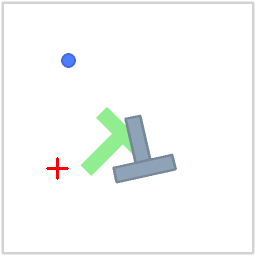

In [60]:
# =========================================================
# TEG 优化版: 细粒度模拟 + 距离门控 + 高噪声探索
# =========================================================

def run_teg_inference_optimized(obstacle_pos_norm, guidance_scale=3.0, N_ensemble=64):
    obs, info = env.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    
    start_img = env.render()
    img_h, img_w = start_img.shape[:2]
    imgs = [start_img]
    
    # 坐标转换 (Visual)
    obs_physics = unnormalize_data(np.array(obstacle_pos_norm), stats=stats['action'])
    env_window_size = getattr(env, 'window_size', 512) 
    scale = img_w / env_window_size
    obs_pixel = (int(obs_physics[0] * scale), int(obs_physics[1] * scale))
    
    # 障碍物 Tensor
    obs_tensor = torch.tensor([obstacle_pos_norm], device=device, dtype=torch.float32)

    a = obs[:action_dim]
    na = normalize_data(a, stats=stats['action'])
    na = torch.from_numpy(na).to(device, dtype=torch.float32)
    na_from_prev_chunk = na.unsqueeze(0).unsqueeze(0)
    
    done = False
    step_idx = 0
    max_steps = 200
    dt_real = 1.0 / (pred_horizon - obs_horizon)
    
    # --- [优化 1] 细粒度模拟参数 ---
    # 不要一步跨 0.4，而是模拟更细致，防止穿透
    K_horizon = 15    # 向前看 15 步
    dt_est = 0.05     # 每步 0.05 (总视野 0.75，覆盖大部分未来)
    
    # --- [优化 2] 门控参数 ---
    # 只有当机器人距离障碍物小于这个距离时，才开启 Guidance
    # 0.5 在归一化空间里大约是 1/4 屏幕宽度
    activation_distance = 0.5
    
    print(f"Running Optimized TEG: N={N_ensemble}, K={K_horizon}, dt_est={dt_est}")
    
    while not done and step_idx < max_steps:
        obs_seq = np.stack(obs_deque)
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
        
        na = na_from_prev_chunk
        
        for i in range(action_horizon):
            # 1. 绘图
            img_rgb = env.render().copy()
            cv2.circle(img_rgb, obs_pixel, 20, (0, 255, 255), -1) # 黄色障碍物
            cv2.circle(img_rgb, obs_pixel, 20, (0, 0, 0), 2)
            
            # 画出当前 Agent 位置 (Debug)
            curr_phys = unnormalize_data(na.detach().cpu().numpy().squeeze(), stats=stats['action'])
            curr_px = (int(curr_phys[0] * scale), int(curr_phys[1] * scale))
            cv2.circle(img_rgb, curr_px, 5, (0, 0, 255), -1) # 红色 Agent
            
            imgs.append(img_rgb)
            
            # 2. 执行
            a_cpu = na.detach().to('cpu').numpy().squeeze()
            a_real = unnormalize_data(a_cpu, stats=stats['action'])
            obs, reward, done, _, info = env.step(a_real)
            obs_deque.append(obs)
            
            step_idx += 1
            if done or step_idx >= max_steps: break
            
            # 3. 计算距离门控 (Distance Gating)
            # 计算当前位置到障碍物的距离
            dist_to_obs = torch.norm(na.squeeze() - obs_tensor.squeeze()).item()
            
            # 4. 准备时间
            t_scalar = np.clip(i * dt_real, 1e-3, 1.0 - 1e-3)
            t_real = torch.tensor([[t_scalar]], device=device, dtype=torch.float32)
            
            # 5. Base Policy Drift
            with torch.no_grad():
                v_real = ema_si_velocity_net(na, t_real.view(-1), o_test)
                eta_real = ema_si_denoiser_net(na, t_real.view(-1), o_test)
                gamma = gamma_t_si(t_real).view(-1, 1, 1)
                g_dot = d_gamma_dt_si(t_real).view(-1, 1, 1)
                s_real = -eta_real / (gamma + 1e-6)
                score_coeff = 0.5 * (0.05**2) - (gamma * g_dot)
                base_drift = v_real + score_coeff * s_real
            
            # 6. TEG Guidance (Conditional Execution)
            grad_teg = torch.zeros_like(base_drift)
            
            # [优化 3] 只有距离足够近时才启动昂贵的 TEG 计算
            if dist_to_obs < activation_distance:
                with torch.enable_grad():
                    a_curr = na.squeeze(1).detach().requires_grad_(True)
                    
                    # Batch Expansion
                    a_ens = a_curr.repeat(N_ensemble, 1)
                    t_ens = t_real.view(-1).repeat(N_ensemble)
                    cond_ens = o_test.repeat(N_ensemble, 1)
                    obs_ens = obs_tensor.repeat(N_ensemble, 1)
                    
                    cum_cost = torch.zeros(N_ensemble, device=device)
                    curr_a_sim = a_ens
                    curr_t_sim = t_ens
                    
                    # 快速模拟循环
                    for k_step in range(K_horizon):
                        t_input = torch.clamp(curr_t_sim, 0.05, 0.95)
                        
                        v_p = ema_si_velocity_net(curr_a_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                        eta_p = ema_si_denoiser_net(curr_a_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                        
                        gamma = gamma_t_si(t_input).view(-1, 1)
                        g_dot = d_gamma_dt_si(t_input).view(-1, 1)
                        s_p = -eta_p / (gamma + 1e-6)
                        
                        # [优化 4] 增大 Estimator 的噪声 (0.05 -> 0.2)
                        # 让"脑内模拟"更发散，更容易发现绕开的路径，而不是全体撞墙
                        sigma_est = 0.2
                        score_coeff = 0.5 * (sigma_est**2) - (gamma * g_dot)
                        b_drift = v_p + score_coeff * s_p
                        
                        # 简单的 Cost 累加
                        # Scale 设小一点，防止梯度爆炸
                        dist_sq = ((curr_a_sim - obs_ens)**2).sum(dim=-1)
                        step_cost = 2.0 * torch.exp(-dist_sq / (2 * 0.25**2))
                        cum_cost += step_cost * dt_est
                        
                        # SDE Update
                        noise = torch.randn_like(curr_a_sim)
                        curr_a_sim = curr_a_sim + b_drift * dt_est + sigma_est * math.sqrt(dt_est) * noise
                        curr_t_sim = curr_t_sim + dt_est
                    
                    # Soft-min Utility
                    neg_cost = -cum_cost
                    log_utility = torch.logsumexp(neg_cost, dim=0)
                    
                    (g,) = torch.autograd.grad(log_utility, a_curr)
                    grad_teg = g.unsqueeze(1)
            
            # 7. 融合
            # 动态调整 guidance scale: 离得越近，力度越大
            # 简单的线性衰减: (1.0 - dist / threshold) * scale
            dynamic_scale = 0.0
            if dist_to_obs < activation_distance:
                dynamic_scale = guidance_scale * (1.0 - dist_to_obs / activation_distance)
            
            total_drift = base_drift + dynamic_scale * grad_teg
            
            # 8. Update
            noise = torch.randn_like(na)
            diffusion = 0.05 * math.sqrt(dt_real) * noise
            na = na + total_drift * dt_real + diffusion
            na = na.detach()

        na_from_prev_chunk = na
        if done: break

    print(f"Final Score: {max(rewards) if rewards else 0}")
    return imgs

# =========================================================
# 运行
# =========================================================
# 障碍物位置：放在必经之路上 (0.2, 0.2)
obstacle_pos = [0.4, 0.2]

# Scale 可以给大一点，因为我们有距离门控和动态衰减
imgs_opt = run_teg_inference_optimized(obstacle_pos, guidance_scale=1.0, N_ensemble=64)

import imageio
save_name = "teg_optimized.gif"
imageio.mimsave(save_name, imgs_opt, fps=20, loop=0)

jviz.gif(imgs_opt, time_in_ms=len(imgs_opt)*50, hold_last_frame_time_in_ms=1000)\
    .html(width=256, pixelated=False, title=f"Optimized TEG").display()

In [64]:
import numpy as np
import torch
import cv2
import collections
import math

# =========================================================
# 辅助函数：绘制箭头
# =========================================================
def draw_vector_arrow(img, start_pt, vector, color, scale=100, thickness=2):
    """
    在图像上绘制表示向量的箭头
    start_pt: (x, y) 像素坐标
    vector: (dx, dy) 归一化空间下的向量
    scale: 放大倍数，用于将微小的梯度数值转换为可见的像素长度
    """
    if vector is None or np.linalg.norm(vector) < 1e-6:
        return
    
    # 计算终点
    end_pt = (int(start_pt[0] + vector[0] * scale), 
              int(start_pt[1] + vector[1] * scale))
    
    # 绘制箭头
    cv2.arrowedLine(img, start_pt, end_pt, color, thickness, tipLength=0.3)

# =========================================================
# TEG 优化版 (含向量可视化)
# =========================================================

def run_teg_inference_visualized(obstacle_pos_norm, guidance_scale=3.0, N_ensemble=64):
    obs, info = env.reset()
    obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
    
    start_img = env.render()
    img_h, img_w = start_img.shape[:2]
    # imgs 列表我们稍后在循环里手动添加，这里先不放 start_img 以免重复
    imgs = [] 
    
    # 坐标转换参数
    obs_physics = unnormalize_data(np.array(obstacle_pos_norm), stats=stats['action'])
    env_window_size = getattr(env, 'window_size', 512) 
    scale = img_w / env_window_size
    obs_pixel = (int(obs_physics[0] * scale), int(obs_physics[1] * scale))
    
    # 障碍物 Tensor
    obs_tensor = torch.tensor([obstacle_pos_norm], device=device, dtype=torch.float32)

    a = obs[:action_dim]
    na = normalize_data(a, stats=stats['action'])
    na = torch.from_numpy(na).to(device, dtype=torch.float32)
    na_from_prev_chunk = na.unsqueeze(0).unsqueeze(0)
    
    done = False
    step_idx = 0
    max_steps = 200
    dt_real = 1.0 / (pred_horizon - obs_horizon)
    
    # TEG 参数
    K_horizon = 5    
    dt_est = 0.15     
    activation_distance = 0.4
    
    # [可视化参数] 向量放大倍数
    arrow_vis_scale = 150.0 
    
    print(f"Running Visualized TEG: N={N_ensemble}, K={K_horizon}")
    
    while not done and step_idx < max_steps:
        obs_seq = np.stack(obs_deque)
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32).flatten().unsqueeze(0)
        
        na = na_from_prev_chunk
        
        for i in range(action_horizon):
            # -------------------------------------------------
            # 1. 物理执行 (Env Step)
            # -------------------------------------------------
            a_cpu = na.detach().to('cpu').numpy().squeeze()
            a_real = unnormalize_data(a_cpu, stats=stats['action'])
            obs, reward, done, _, info = env.step(a_real)
            obs_deque.append(obs)
            
            step_idx += 1
            if done or step_idx >= max_steps: break
            
            # -------------------------------------------------
            # 2. 计算 Drift (Base Policy)
            # -------------------------------------------------
            # 准备时间
            t_scalar = np.clip(i * dt_real, 1e-3, 1.0 - 1e-3)
            t_real = torch.tensor([[t_scalar]], device=device, dtype=torch.float32)
            
            # Base Policy Drift
            with torch.no_grad():
                v_real = ema_si_velocity_net(na, t_real.view(-1), o_test)
                eta_real = ema_si_denoiser_net(na, t_real.view(-1), o_test)
                gamma = gamma_t_si(t_real).view(-1, 1, 1)
                g_dot = d_gamma_dt_si(t_real).view(-1, 1, 1)
                s_real = -eta_real / (gamma + 1e-6)
                score_coeff = 0.5 * (0.05**2) - (gamma * g_dot)
                base_drift = v_real + score_coeff * s_real
            
            # -------------------------------------------------
            # 3. 计算 Guidance (TEG)
            # -------------------------------------------------
            dist_to_obs = torch.norm(na.squeeze() - obs_tensor.squeeze()).item()
            grad_teg = torch.zeros_like(base_drift)
            dynamic_scale = 0.0
            
            if dist_to_obs < activation_distance:
                with torch.enable_grad():
                    a_curr = na.squeeze(1).detach().requires_grad_(True)
                    
                    # Batch Expansion
                    a_ens = a_curr.repeat(N_ensemble, 1)
                    t_ens = t_real.view(-1).repeat(N_ensemble)
                    cond_ens = o_test.repeat(N_ensemble, 1)
                    obs_ens = obs_tensor.repeat(N_ensemble, 1)
                    
                    cum_cost = torch.zeros(N_ensemble, device=device)
                    curr_a_sim = a_ens
                    curr_t_sim = t_ens
                    
                    # 模拟循环
                    for k_step in range(K_horizon):
                        t_input = torch.clamp(curr_t_sim, 0.05, 0.95)
                        v_p = ema_si_velocity_net(curr_a_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                        eta_p = ema_si_denoiser_net(curr_a_sim.unsqueeze(1), t_input, cond_ens).squeeze(1)
                        gamma = gamma_t_si(t_input).view(-1, 1)
                        g_dot = d_gamma_dt_si(t_input).view(-1, 1)
                        s_p = -eta_p / (gamma + 1e-6)
                        
                        sigma_est = 0.2 
                        score_coeff = 0.5 * (sigma_est**2) - (gamma * g_dot)
                        b_drift = v_p + score_coeff * s_p
                        
                        # Cost Calculation
                        dist_sq = ((curr_a_sim - obs_ens)**2).sum(dim=-1)
                        step_cost = 0.5 * torch.exp(-dist_sq / (2 * 0.1**2))
                        cum_cost += step_cost * dt_est
                        
                        # Update Simulation
                        noise = torch.randn_like(curr_a_sim)
                        curr_a_sim = curr_a_sim + b_drift * dt_est + sigma_est * math.sqrt(dt_est) * noise
                        curr_t_sim = curr_t_sim + dt_est
                    
                    # Gradient Calculation
                    neg_cost = -cum_cost
                    log_utility = torch.logsumexp(neg_cost, dim=0)
                    (g,) = torch.autograd.grad(log_utility, a_curr)
                    grad_teg = g.unsqueeze(1)
                
                # Dynamic Scale
                dynamic_scale = guidance_scale * (1.0 - dist_to_obs / activation_distance)

            # -------------------------------------------------
            # 4. 可视化绘制 (Render with Arrows)
            # -------------------------------------------------
            img_rgb = env.render().copy()
            
            # 绘制静态障碍物 (黄色)
            cv2.circle(img_rgb, obs_pixel, 6, (0, 255, 255), -1) 
            cv2.circle(img_rgb, obs_pixel, 6, (0, 0, 0), 2)
            
            # 计算 Agent 像素位置
            curr_phys = unnormalize_data(na.detach().cpu().numpy().squeeze(), stats=stats['action'])
            curr_px = (int(curr_phys[0] * scale), int(curr_phys[1] * scale))
            
            # 绘制 Agent (红色)
            cv2.circle(img_rgb, curr_px, 8, (0, 0, 255), -1)
            
            # === [核心修改] 绘制向量 ===
            # 获取向量数值 (转 numpy)
            vec_base = base_drift.detach().cpu().numpy().squeeze()
            vec_teg = (grad_teg * dynamic_scale).detach().cpu().numpy().squeeze()
            
            # 1. Base Drift (原始意图) -> 蓝色箭头 (BGR: 255, 0, 0)
            draw_vector_arrow(img_rgb, curr_px, vec_base, (255, 0, 0), scale=arrow_vis_scale, thickness=2)
            
            # 2. TEG Guidance (斥力) -> 红色箭头 (BGR: 0, 0, 255)
            # 只有当 dynamic_scale > 0 时才画
            if dynamic_scale > 1e-4:
                draw_vector_arrow(img_rgb, curr_px, vec_teg, (0, 0, 255), scale=arrow_vis_scale, thickness=2)
                
                # 可选：显示文字 "TEG ACTIVE"
                cv2.putText(img_rgb, "TEG ACTIVE", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            imgs.append(img_rgb)
            
            # -------------------------------------------------
            # 5. 更新 Agent 状态 (Diffusion Update)
            # -------------------------------------------------
            total_drift = base_drift + dynamic_scale * grad_teg
            
            noise = torch.randn_like(na)
            diffusion = 0.05 * math.sqrt(dt_real) * noise
            na = na + total_drift * dt_real + diffusion
            na = na.detach()

        na_from_prev_chunk = na
        if done: break

    print(f"Final Score: {max(rewards) if rewards else 0}")
    return imgs

# =========================================================
# 运行并生成 GIF
# =========================================================
obstacle_pos = [0.0, 0.5]

# 这里的 guidance_scale 可以适当调大一点，以便在 GIF 中看到更明显的红色箭头
imgs_viz = run_teg_inference_visualized(obstacle_pos, guidance_scale=1.0, N_ensemble=64)

import imageio
save_name = "teg_visualized_arrows.gif"
imageio.mimsave(save_name, imgs_viz, fps=20, loop=0)

# 如果是在 Notebook 中，可以显示
try:
    import jviz
    jviz.gif(imgs_viz, time_in_ms=len(imgs_viz)*50, hold_last_frame_time_in_ms=1000)\
        .html(width=512, pixelated=False, title=f"TEG Vectors").display()
except:
    print(f"GIF saved to {save_name}")

Running Visualized TEG: N=64, K=5
Final Score: 0
GIF saved to teg_visualized_arrows.gif
